In [1]:
#devtools::install_gitlab("sysbiobig/sparsim", build_opts = c("--no-resave-data", "--no-manual"), build_vignettes = TRUE)
#install.packages(c("Seurat", "deplyr", "stringr"))
#BiocManager::install(c("qusage", "edgeR", "mclust", "scater", "scran"))

In [2]:
library(SPARSim)
library(dplyr)
library(Seurat)
library(qusage)
library(stringr)
library(ggplot2)
library('biomaRt')



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject

Loading required package: limma



In [3]:
use_file = "go_human.bp.gmt"
use_file = "reactome_pathways.gmt"
use_file = "c7.immunesigdb.v2023.2.Hs.symbols.gmt"
use_file = "c2.all.v2023.2.Hs.symbols.gmt"

pathways <- qusage::read.gmt(use_file)

In [4]:
#c("Tung_param_preset", "Camp_param_preset", "Engel_param_preset", "Chu_param_preset", "Horning_param_preset", "Bacher_param_preset", "Brain_10X_param_preset", "T_10X_param_preset", "PBMC_10X_param_preset", "Zheng_param_preset", "Macosko_param_preset", "Saunders_param_preset")
# should match reactome names
data("PBMC_10X_param_preset")
intensity= PBMC_10X_param_preset[[1]]$intensity

genes_df=data.frame(names=names(intensity))

mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id","hgnc_symbol"),values=genes_df$name,mart= mart)

genes_df= merge(genes_df,G_list,by.x="names",by.y="ensembl_gene_id",all.x=TRUE)

genes_df$hgnc_symbol[duplicated(genes_df$hgnc_symbol)] <- NA

genes_df[is.na(genes_df$hgnc_symbol),]$hgnc_symbol=paste0("NA_",1:sum(is.na(genes_df$hgnc_symbol)))

genes=genes_df$hgnc_symbol
names(intensity)=genes

keepIndices = grep("^NA_", names(intensity), invert=T)
intensity = intensity[ keepIndices ]
variability = PBMC_10X_param_preset[[1]]$variability[ keepIndices ]

n_genes=length(genes)
library_size=PBMC_10X_param_preset[[1]]$lib_size  * 10 ### here lib factor
n_cells=length(library_size)
genes=names(intensity)

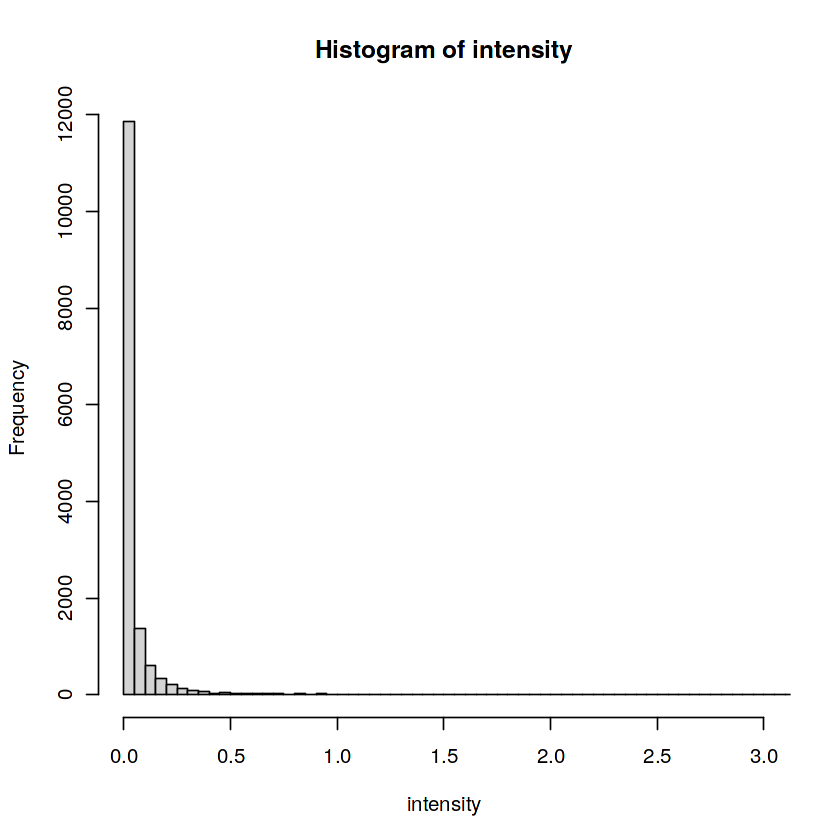

In [5]:
hist(intensity, xlim = c(0, 3), breaks=2000)

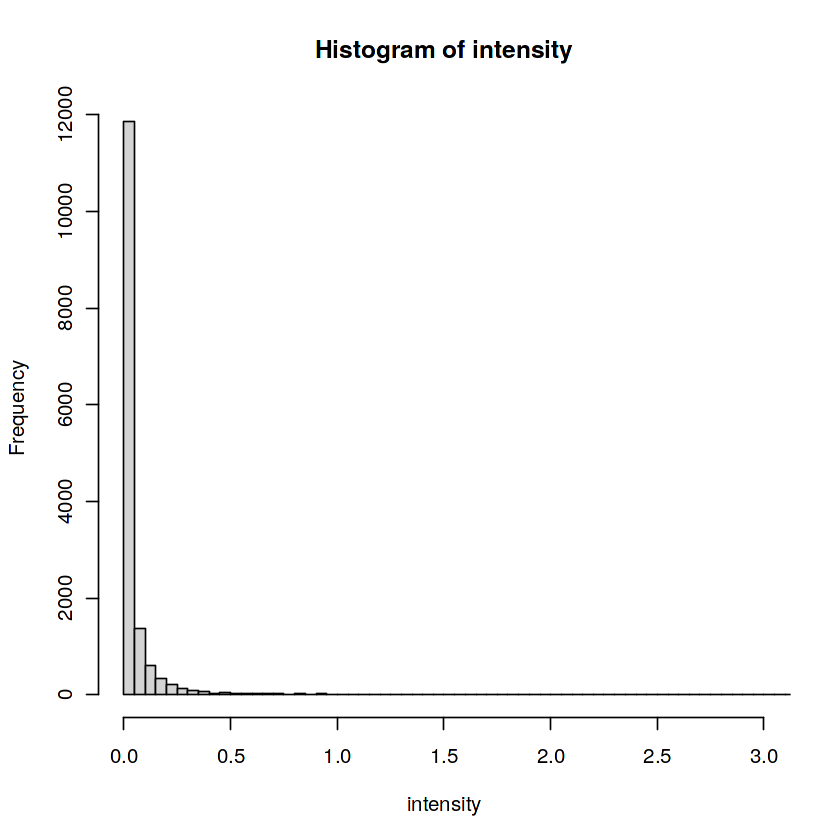

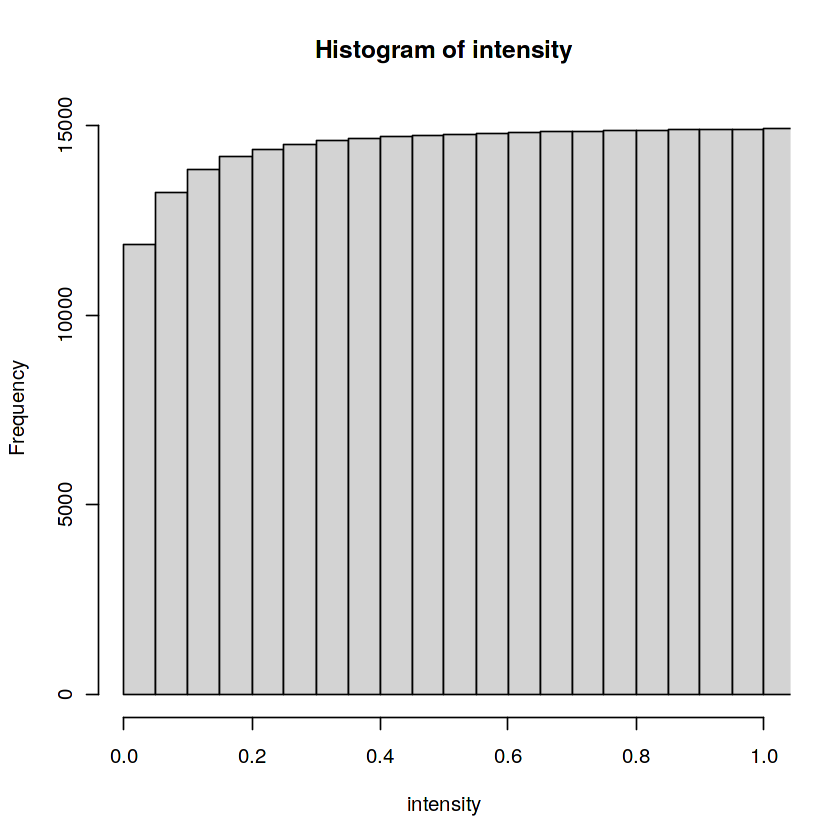

In [6]:
h=hist(intensity, xlim = c(0, 3), breaks=2000)
h[["counts"]] <- cumsum(h[["counts"]])
plot(h, xlim = c(0, 1))

In [7]:
highIntensityGenes = names(intensity[intensity > 0.05])

In [8]:
print(paste(length(intensity), length(highIntensityGenes), length(highIntensityGenes)/length(intensity)))

[1] "15104 3240 0.214512711864407"


In [9]:
keepPWs = c()

for (pw in names(pathways))
{
    numGenes = length(pathways[[pw]])
    numHighIntensityGenes = length(intersect(highIntensityGenes, pathways[[pw]]))

    highIntensityRatio = numHighIntensityGenes / numGenes

    if ((numGenes > 1) && (highIntensityRatio > 0.4))
    {
        print(paste(pw, numGenes, numHighIntensityGenes))
        keepPWs = c(keepPWs, pw)
    }
}

[1] "AMIT_EGF_RESPONSE_40_MCF10A 17 8"
[1] "CAFFAREL_RESPONSE_TO_THC_8HR_5_UP 15 7"
[1] "DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN 9 4"
[1] "DASU_IL6_SIGNALING_DN 7 3"
[1] "FARDIN_HYPOXIA_9 7 4"
[1] "FINETTI_BREAST_CANCER_KINOME_RED 16 7"
[1] "GHO_ATF5_TARGETS_UP 13 6"
[1] "GREENBAUM_E2A_TARGETS_DN 18 8"
[1] "HEDENFALK_BREAST_CANCER_BRACX_UP 19 8"
[1] "IIZUKA_LIVER_CANCER_EARLY_RECURRENCE 11 5"
[1] "IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN 9 5"
[1] "IM_SREBF1A_TARGETS 5 3"
[1] "KIM_GERMINAL_CENTER_T_HELPER_DN 12 5"
[1] "KONDO_HYPOXIA 8 5"
[1] "MAINA_HYPOXIA_VHL_TARGETS_UP 6 3"
[1] "MCBRYAN_TERMINAL_END_BUD_DN 6 3"
[1] "MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN 11 7"
[1] "MUNSHI_MULTIPLE_MYELOMA_DN 10 5"
[1] "OUYANG_PROSTATE_CANCER_PROGRESSION_UP 21 9"
[1] "PETRETTO_LEFT_VENTRICLE_MASS_QTL_CIS_DN 10 7"
[1] "RAMPON_ENRICHED_LEARNING_ENVIRONMENT_EARLY_DN 10 5"
[1] "SARTIPY_BLUNTED_BY_INSULIN_RESISTANCE_UP 17 7"
[1] "STONER_ESOPHAGEAL_CARCINOGENESIS_DN 7 3"
[1] "TERAMOTO_OPN_TARGETS_CLU

In [10]:
trends=list("trend1"=c(1,4,1,1), "trend2"=c(8, 2, 1, 1), "trend3"=c(1,2,4, 1), "trend4"=c(1, 2, 2, 8))
trends

$trend1
[1] 1 4 1 1

$trend2
[1] 8 2 1 1

$trend3
[1] 1 2 4 1

$trend4
[1] 1 2 2 8

In [11]:
#Set states
states=c("wildtype","stage1","stage2","stage3")
states

[1] "wildtype" "stage1"   "stage2"   "stage3"

In [12]:

num_pws_per_trend=10

trend2pw = list()
trend2genes = list()
trend2count = list()
pw2pwgenes = list()

for (trend in names(trends))
{
    trend2count[[trend]] = 0
}

for (pw in keepPWs)
{
    #print(pw)
    pwGenes = pathways[[pw]]
    pwGenes = intersect(pwGenes, names(intensity))
    #print(pwGenes)

    intersections = list()
    
    for (trend in names(trends))
    {
        if (trend %in% names(trend2genes))
        {
            commonGenes = intersect(pwGenes, trend2genes[[trend]])
            if (length(commonGenes) > 0)
            {
                intersections[[trend]] = length(commonGenes)
            }
        }
    }

    curtrend = NULL
    if (length(names(intersections)) == 1)
    {
        #print("One Intersection")
        nexttrend = names(intersections)[1]

        if (trend2count[[nexttrend]] < num_pws_per_trend)
        {
            curtrend = nexttrend
        }

    } else if (length(names(intersections)) == 0)
    {

        #print("No Intersection")
        for (trend in names(trends))
        {
            if (trend2count[[trend]] < num_pws_per_trend)   
            {
                curtrend = trend
                break       
            }
        }

    }

    #print(curstate)

    if (!is.null(curtrend))
    {
        #print(curstate)
        if (curtrend %in% names(trend2genes))
        {
            #print("Add case")
            trend2genes[[curtrend]] = unique(c(trend2genes[[curtrend]], pwGenes))
            trend2pw[[curtrend]] = c(trend2pw[[curtrend]], pw)
        } else {
            #print("init case")
            trend2genes[[curtrend]] = unique(c(pwGenes))
            trend2pw[[curtrend]] = c(pw)
        }

        pw2pwgenes[[pw]] = pwGenes
        trend2count[[curtrend]] = trend2count[[curtrend]] + 1
        

    }

}

for (trend in names(trend2pw))
{
    trendGenes = c()
    for (pw in trend2pw[[trend]])
    {
        pwgene_count = length(pw2pwgenes[[pw]])
        trendGenes = c(trendGenes, pw2pwgenes[[pw]])
        print(paste(trend, pw, pwgene_count))
    }

    print(paste(trend, length(unique(trendGenes))))
    print("")
}

[1] "trend1 AMIT_EGF_RESPONSE_40_MCF10A 16"
[1] "trend1 CAFFAREL_RESPONSE_TO_THC_8HR_5_UP 15"
[1] "trend1 DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN 9"
[1] "trend1 DASU_IL6_SIGNALING_DN 5"
[1] "trend1 FARDIN_HYPOXIA_9 7"
[1] "trend1 FINETTI_BREAST_CANCER_KINOME_RED 15"
[1] "trend1 GHO_ATF5_TARGETS_UP 11"
[1] "trend1 GREENBAUM_E2A_TARGETS_DN 18"
[1] "trend1 HEDENFALK_BREAST_CANCER_BRACX_UP 18"
[1] "trend1 IIZUKA_LIVER_CANCER_EARLY_RECURRENCE 11"
[1] "trend1 122"
[1] ""
[1] "trend2 IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN 9"
[1] "trend2 IM_SREBF1A_TARGETS 5"
[1] "trend2 KIM_GERMINAL_CENTER_T_HELPER_DN 12"
[1] "trend2 MCBRYAN_TERMINAL_END_BUD_DN 6"
[1] "trend2 MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN 10"
[1] "trend2 MUNSHI_MULTIPLE_MYELOMA_DN 9"
[1] "trend2 PETRETTO_LEFT_VENTRICLE_MASS_QTL_CIS_DN 10"
[1] "trend2 RAMPON_ENRICHED_LEARNING_ENVIRONMENT_EARLY_DN 10"
[1] "trend2 STONER_ESOPHAGEAL_CARCINOGENESIS_DN 7"
[1] "trend2 TSUDA_ALVEOLAR_SOFT_PART_SARCOMA 8"
[1] "trend2 85"
[1] ""
[1] 

In [13]:
pw2trends=list()
for (trend in names(trend2pw))
{
    for (pw in trend2pw[[trend]])
    {
        pw2trends[[pw]] = c(pw2trends[[pw]], trend)
    }
}

print(head(pw2trends))

$AMIT_EGF_RESPONSE_40_MCF10A
[1] "trend1"

$CAFFAREL_RESPONSE_TO_THC_8HR_5_UP
[1] "trend1"

$DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN
[1] "trend1"

$DASU_IL6_SIGNALING_DN
[1] "trend1"

$FARDIN_HYPOXIA_9
[1] "trend1"

$FINETTI_BREAST_CANCER_KINOME_RED
[1] "trend1"



In [14]:
# use TF-link databases from https://github.com/slowkow/tftargets
library(tftargets)

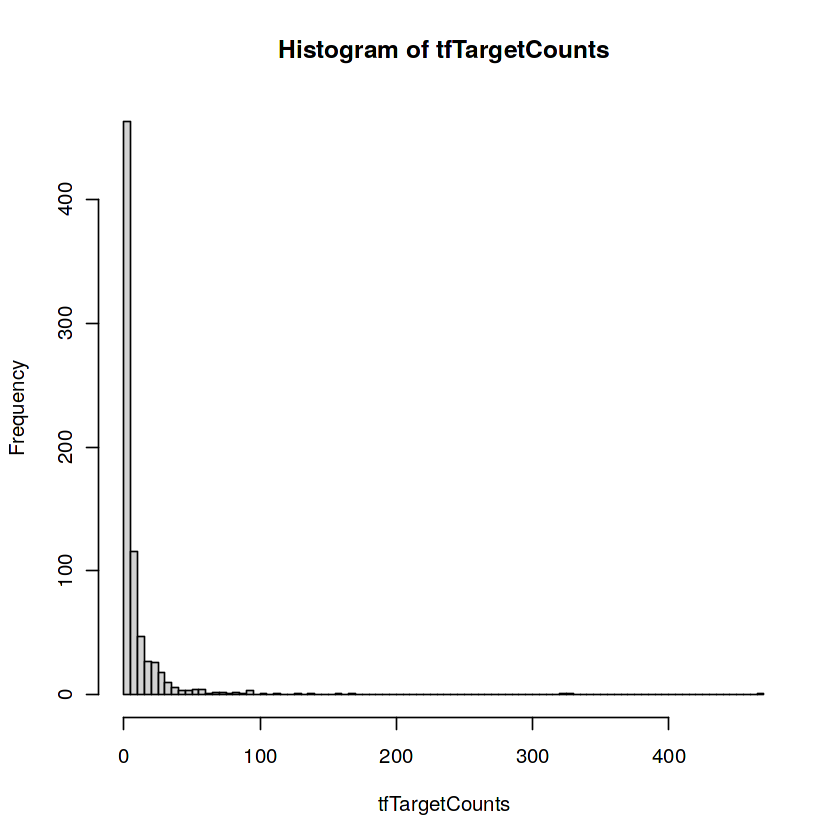

In [15]:
tfTargetCounts = c()
for (tf in names(TRRUST))
{
    targets = TRRUST[[tf]]

    tfTargetCounts = c(tfTargetCounts, length(targets))
}

hist(tfTargetCounts, breaks = 100)

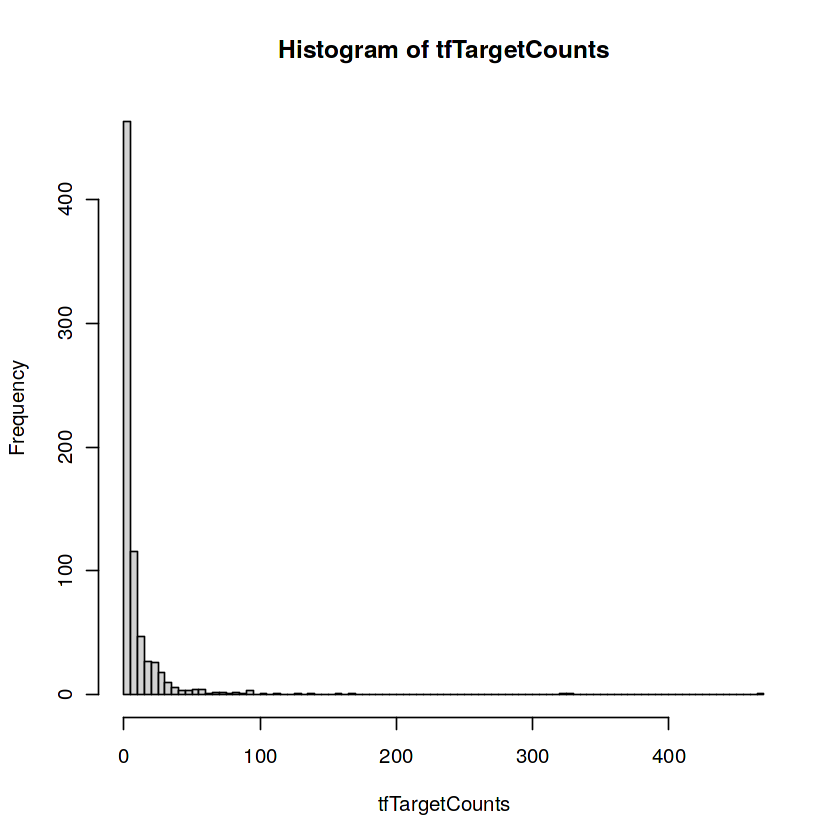

In [16]:
geneTFs = list()

for (tf in names(TRRUST)){
    targets = TRRUST[[tf]]

    for (tgene in targets)
    {
        if (!tgene %in% geneTFs)
        {
            geneTFs[[tgene]] = 0
        }

        geneTFs[[tgene]] = geneTFs[[tgene]] + 1
    }

}

hist(tfTargetCounts, breaks = 100)

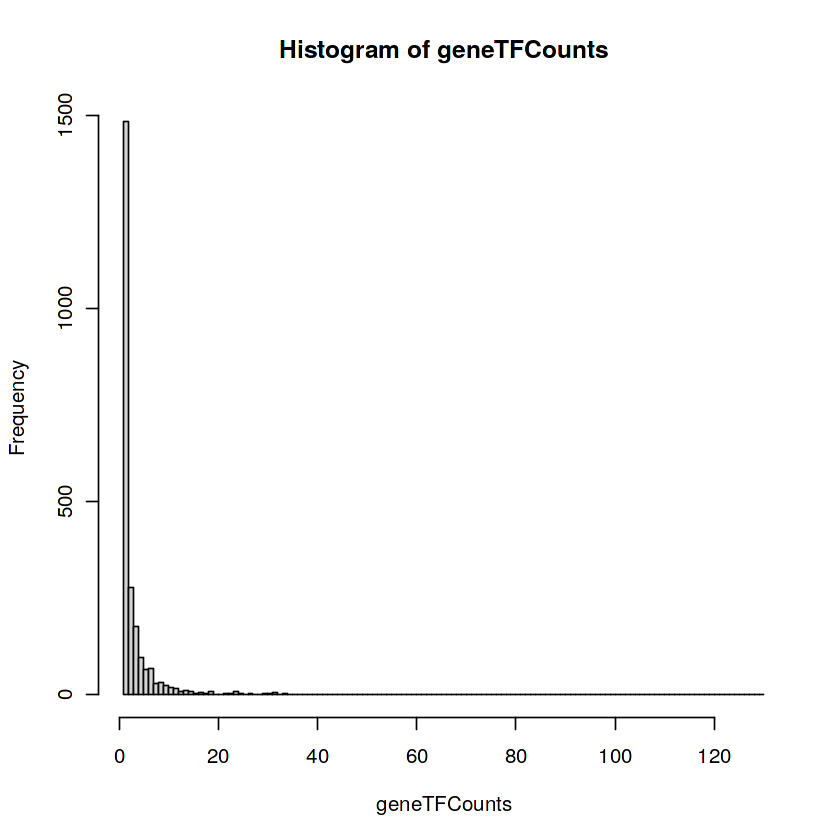

In [17]:
gene2tf = list()

for (tf in names(TRRUST))
{
    targets = TRRUST[[tf]]

    for (gene in targets)
    {
        if (!gene %in% names(gene2tf))
        {
            gene2tf[[gene]] = c()
        }

        gene2tf[[gene]] = c(gene2tf[[gene]], tf)
    }
}

geneTFCounts = c()
for (tgene in names(gene2tf))
{
    geneTFCounts = c(geneTFCounts, length(gene2tf[[tgene]]))
}
hist(geneTFCounts, breaks = 100)

In [18]:
for (trend in names(trend2genes))
{

    for (gene in trend2genes[[trend]])
    {
        tfcountforgene = 0
        if (gene %in% names(geneTFCounts))
        {
            tfcountforgene = geneTFCounts[[gene]]
        }
        if (gene %in% names(TRRUST))
        {
            next
        }
        
        print(paste(trend, gene, tfcountforgene))
    }    
}

[1] "trend1 ADM 0"
[1] "trend1 BUB1 0"
[1] "trend1 DUSP5 0"
[1] "trend1 GNS 0"
[1] "trend1 HSDL2 0"
[1] "trend1 MIS18BP1 0"
[1] "trend1 NDUFB6 0"
[1] "trend1 TIMM44 0"
[1] "trend1 TUFT1 0"
[1] "trend1 UNC93B1 0"
[1] "trend1 AIMP2 0"
[1] "trend1 CDKN1B 0"
[1] "trend1 CTSL 0"
[1] "trend1 GARS1 0"
[1] "trend1 GOLGB1 0"
[1] "trend1 IPO7 0"
[1] "trend1 NEAT1 0"
[1] "trend1 OSER1 0"
[1] "trend1 SRRM2 0"
[1] "trend1 STX5 0"
[1] "trend1 TES 0"
[1] "trend1 USP3 0"
[1] "trend1 ACTB 0"
[1] "trend1 EIF4A1 0"
[1] "trend1 GAPDH 0"
[1] "trend1 HSP90AB1 0"
[1] "trend1 MIR22HG 0"
[1] "trend1 SERPINE1 0"
[1] "trend1 ASNS 0"
[1] "trend1 SEPTIN11 0"
[1] "trend1 TMBIM6 0"
[1] "trend1 TPM1 0"
[1] "trend1 AK4 0"
[1] "trend1 ALDOC 0"
[1] "trend1 BNIP3 0"
[1] "trend1 DDIT4 0"
[1] "trend1 FAM162A 0"
[1] "trend1 PDK1 0"
[1] "trend1 VEGFA 0"
[1] "trend1 AURKA 0"
[1] "trend1 AURKB 0"
[1] "trend1 CDC7 0"
[1] "trend1 CDK1 0"
[1] "trend1 CHEK1 0"
[1] "trend1 MASTL 0"
[1] "trend1 MELK 0"
[1] "trend1 NEK2 0"
[1] "trend

In [19]:
trend2tfs = list()
tfnetwork = list()

for (trend in names(trend2genes))
{
    sgenes = unique(trend2genes[[trend]])
    
    relTFs = unlist(gene2tf[sgenes])

    tfCounts = (-1*sort(-1*table(relTFs)))
    multiTFs = names(tfCounts[tfCounts>1])

    targetTFs = c()
    for (sgene in sgenes)
    {
        sgeneTFs = gene2tf[[sgene]]

        if (is.null(sgeneTFs))
        {
            next
        }

        existingTFIntersect = intersect(sgenes, sgeneTFs)
        # TF is in geneset ...
        if (length(existingTFIntersect) > 0)
        {
            for (tfgene in existingTFIntersect)
            {
                tfnetwork[[length(tfnetwork)+1]] = c(tfgene, sgene)
            }
            
            next
        }

        # relevant TF already in TF list
        if (length(intersect(targetTFs, sgeneTFs)) > 0)
        {

            for (tfgene in intersect(targetTFs, sgeneTFs))
            {
                tfnetwork[[length(tfnetwork)+1]] = c(tfgene, sgene)
            }
            

            next
        }

        if (length(intersect(multiTFs, sgeneTFs)) > 0)
        {
            useTF = sample(intersect(multiTFs, sgeneTFs)[1], size = 1)
            targetTFs = unique(c(targetTFs, useTF))

            tfnetwork[[length(tfnetwork)+1]] = c(useTF, sgene)
        } else {
            useTF = sample(sgeneTFs, size = 1)
            targetTFs = unique(c(targetTFs, useTF))
            tfnetwork[[length(tfnetwork)+1]] = c(useTF, sgene)
        }
    }
    
    trend2tfs[[trend]] = targetTFs
    
}

print(trend2tfs)

$trend1
 [1] "CEBPB"  "TP53"   "NFATC2" "NR1I2"  "STAT3"  "RBMX"   "E2F4"   "HIF1A" 
 [9] "ATF4"   "E2F1"   "SP3"    "PAX5"   "NFKB1"  "SP1"    "IRF3"   "HDAC1" 
[17] "GATA4"  "SMAD4"  "APC"   

$trend2
 [1] "HDAC3"  "SP1"    "SIRT1"  "STAT3"  "JUN"    "E2F1"   "STAT6"  "PPARG" 
 [9] "TP53"   "CREBBP" "SMAD4"  "NR1I2"  "AR"     "TWIST1" "ESR2"  

$trend3
 [1] "AR"      "BRCA1"   "ESR1"    "ZNF382"  "NFIC"    "DR1"     "MYB"    
 [8] "TP53"    "MYC"     "IRF1"    "MYBL2"   "SP1"     "CEBPZ"   "STAT4"  
[15] "SERTAD1" "JUN"    

$trend4
[1] "E2F1"  "SP1"   "STAT1" "EGR1" 



In [20]:
net_df=data.frame(Reduce(rbind, tfnetwork))
colnames(net_df)=c("TF", "gene")
head(net_df)

write.table(net_df,file = "simulated_network.tsv",sep="\t",row.names = FALSE,col.names=TRUE,quote = FALSE)

TF     gene
init CEBPB  ADM 
X    TP53   EGR1
X.1  NFATC2 EGR3
X.2  FOS    FOS 
X.3  JUN    FOS 
X.4  JUN    JUN

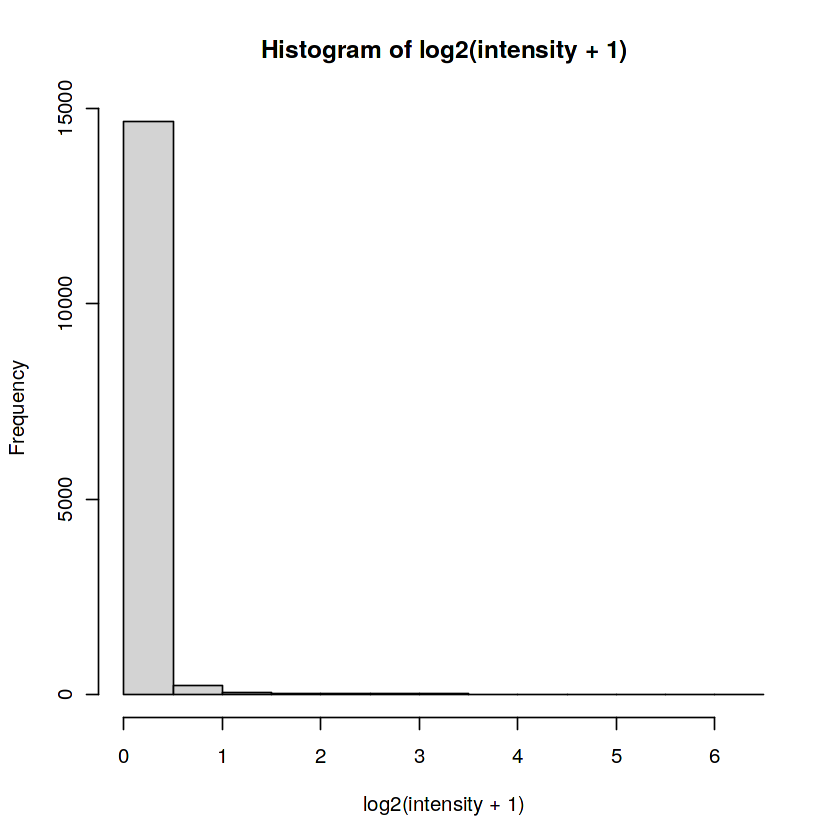

In [21]:
hist(log2(intensity+1))

In [22]:
changes=list()
changes_detail=list()

for(i in 1:length(trends)){

  trendname = names(trend2pw)[i]
  
  for (pw in trend2pw[[trendname]])
  {
    changes[[pw]] = as.vector(unlist(trends[i]))

    for (gene in pw2pwgenes[[pw]])
    {
        changes_detail[[length(changes_detail)+1]] = c(as.vector(unlist(trends[i])), pw, trendname, "gene", gene)
    }
  }

  for (tf in trend2tfs[[trendname]])
  {
        changes_detail[[length(changes_detail)+1]] = c(as.vector(unlist(trends[i])), pw, trendname, "tf", tf)
  }
}

changes[["endoplasmic reticulum-plasma membrane tethering"]]

NULL

In [23]:
for (pw in names(changes))
{
    print(paste(pw, paste(changes[[pw]], collapse=";")))
}

[1] "AMIT_EGF_RESPONSE_40_MCF10A 1;4;1;1"
[1] "CAFFAREL_RESPONSE_TO_THC_8HR_5_UP 1;4;1;1"
[1] "DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN 1;4;1;1"
[1] "DASU_IL6_SIGNALING_DN 1;4;1;1"
[1] "FARDIN_HYPOXIA_9 1;4;1;1"
[1] "FINETTI_BREAST_CANCER_KINOME_RED 1;4;1;1"
[1] "GHO_ATF5_TARGETS_UP 1;4;1;1"
[1] "GREENBAUM_E2A_TARGETS_DN 1;4;1;1"
[1] "HEDENFALK_BREAST_CANCER_BRACX_UP 1;4;1;1"
[1] "IIZUKA_LIVER_CANCER_EARLY_RECURRENCE 1;4;1;1"
[1] "IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN 8;2;1;1"
[1] "IM_SREBF1A_TARGETS 8;2;1;1"
[1] "KIM_GERMINAL_CENTER_T_HELPER_DN 8;2;1;1"
[1] "MCBRYAN_TERMINAL_END_BUD_DN 8;2;1;1"
[1] "MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN 8;2;1;1"
[1] "MUNSHI_MULTIPLE_MYELOMA_DN 8;2;1;1"
[1] "PETRETTO_LEFT_VENTRICLE_MASS_QTL_CIS_DN 8;2;1;1"
[1] "RAMPON_ENRICHED_LEARNING_ENVIRONMENT_EARLY_DN 8;2;1;1"
[1] "STONER_ESOPHAGEAL_CARCINOGENESIS_DN 8;2;1;1"
[1] "TSUDA_ALVEOLAR_SOFT_PART_SARCOMA 8;2;1;1"
[1] "ZIRN_TRETINOIN_RESPONSE_DN 1;2;4;1"
[1] "BIOCARTA_ERBB3_PATHWAY 1;2;4;1"
[1] 

In [24]:
changes_df=data.frame(Reduce(rbind, changes))
rownames(changes_df)=names(changes)
colnames(changes_df)=c(states)
head(changes_df)

wildtype stage1 stage2 stage3
AMIT_EGF_RESPONSE_40_MCF10A                    1        4      1      1     
CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              1        4      1      1     
DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN 1        4      1      1     
DASU_IL6_SIGNALING_DN                          1        4      1      1     
FARDIN_HYPOXIA_9                               1        4      1      1     
FINETTI_BREAST_CANCER_KINOME_RED               1        4      1      1

In [25]:
printChanges = changes_df
printChanges$pathway = rownames(printChanges)

write.table(printChanges,file = "simulated_changes.tsv",sep="\t",row.names = FALSE,col.names=TRUE,quote = FALSE)

In [26]:
changes_df=data.frame(Reduce(rbind, changes_detail))
colnames(changes_df)=c(states, "geneset", "trend", "element_type", "gene")
head(changes_df)

#printChanges = changes_df
#printChanges$pathway = rownames(printChanges)

write.table(changes_df,file = "simulated_changes_detail.tsv",sep="\t",row.names = FALSE,col.names=TRUE,quote = FALSE)

wildtype stage1 stage2 stage3 geneset                     trend 
init 1        4      1      1      AMIT_EGF_RESPONSE_40_MCF10A trend1
X    1        4      1      1      AMIT_EGF_RESPONSE_40_MCF10A trend1
X.1  1        4      1      1      AMIT_EGF_RESPONSE_40_MCF10A trend1
X.2  1        4      1      1      AMIT_EGF_RESPONSE_40_MCF10A trend1
X.3  1        4      1      1      AMIT_EGF_RESPONSE_40_MCF10A trend1
X.4  1        4      1      1      AMIT_EGF_RESPONSE_40_MCF10A trend1
     element_type gene 
init gene         ADM  
X    gene         BUB1 
X.1  gene         DUSP5
X.2  gene         EGR1 
X.3  gene         EGR3 
X.4  gene         FOS

In [27]:
trends

$trend1
[1] 1 4 1 1

$trend2
[1] 8 2 1 1

$trend3
[1] 1 2 4 1

$trend4
[1] 1 2 2 8

In [28]:
states

[1] "wildtype" "stage1"   "stage2"   "stage3"

In [29]:
#Set scaling for changes
#Here for every state a scaling factor can be set which will be applied to every gene in the geneset

set.seed(42)

parameter_list=lapply(states,function(x)
  list(intensity=intensity,multipliers=intensity, variability=variability,library_size=library_size,feature_names=genes,sample_names=paste0(x,"-Cell",1:n_cells),condition_name=x)
  )
names(parameter_list)=states

parameter_list = lapply(parameter_list, function(x) {x$multipliers[1:length(x$multipliers)] = 1; return(x) })

geneNames = names(intensity)

# generates the scaling factors for each gene
for (trend in names(trend2genes))
{
    scaling=trends[[trend]]
    geneset=unique(intersect(trend2genes[[trend]], geneNames))
    for(i in 1:length(parameter_list)){
        name_i=names(parameter_list)[i]
        parameter_list[[i]]$multipliers[geneNames %in% geneset]=pmax(parameter_list[[i]]$multipliers[geneNames %in% geneset], scaling[i])
    }
}

for (trend in names(trend2tfs))
{
    scaling=trends[[trend]]
    geneset = unique(intersect(trend2tfs[[trend]], names(intensity)))
    geneset = setdiff(geneset, trend2genes[[trend]])
    for(i in 1:length(parameter_list)){
        name_i=names(parameter_list)[i]
        parameter_list[[i]]$multipliers[geneNames %in% geneset]=pmax(parameter_list[[i]]$multipliers[geneNames %in% geneset], scaling[i])
    }     
}

parameter_list = lapply(parameter_list, function(x) {x$intensity = x$intensity * x$multipliers; return(x) })

tmpMultiplier = parameter_list[[1]]$multipliers[parameter_list[[1]]$multipliers > 0]
print(head(tmpMultiplier[order(-tmpMultiplier)]))

  CREBBP     PDK2 PAFAH1B1  TSPAN17    RAD51     CYBA 
       8        8        8        8        8        8 


In [30]:
print(summary(parameter_list))
intensity_matrix=do.call(cbind,lapply(parameter_list,function(x)x$intensity))
print("Changing genes:")
intensity_matrix[unlist(apply(intensity_matrix, 1, sd, na.rm = TRUE))!=0, ]

         Length Class  Mode
wildtype 7      -none- list
stage1   7      -none- list
stage2   7      -none- list
stage3   7      -none- list
[1] "Changing genes:"


wildtype     stage1       stage2       stage3      
CREBBP   0.0297618668 0.0074404667 0.0148809334 0.0037202333
PDK2     0.5942512908 0.1485628227 0.0742814113 0.0742814113
PAFAH1B1 0.5334331700 0.1333582925 0.0666791462 0.0666791462
E2F2     0.0095133217 0.0380532870 0.0095133217 0.0095133217
PLAUR    0.0304703484 0.0609406967 0.0609406967 0.2437627868
BRCA1    0.0065089800 0.0130179599 0.0260359199 0.0065089800
CD74     0.0137432106 0.0549728424 0.0137432106 0.0137432106
VIM      0.1437735068 0.5750940274 0.1437735068 0.1437735068
IFT88    0.2166565544 0.8666262174 0.2166565544 0.2166565544
TMSB10   0.0043490451 0.0173961805 0.0043490451 0.0043490451
TSPAN17  0.4213176184 0.1053294046 0.0526647023 0.0526647023
RAD51    0.0027412076 0.0006853019 0.0003426510 0.0003426510
CYBA     0.9497508184 0.2374377046 0.1187188523 0.1187188523
NOP58    0.0003888023 0.0015552091 0.0003888023 0.0003888023
CYFIP2   0.0005607455 0.0022429818 0.0005607455 0.0005607455
TAB2     0.1895452266 0.7581809063 0.1895452266 0.1895452266
ATP11B   0.0737124550 0.2948498199 0.0737124550 0.0737124550
ALDH18A1 0.0035944648 0.0071889296 0.0071889296 0.0287557182
OAT      0.1398579276 0.2797158551 0.2797158551 1.1188634205
ERBB3    0.0888190444 0.1776380889 0.3552761777 0.0888190444
KLF6     0.0012210558 0.0048842233 0.0012210558 0.0012210558
PYGM     0.0015337451 0.0030674903 0.0061349806 0.0015337451
SDK2     1.3424987455 0.3356246864 0.1678123432 0.1678123432
RORA     5.2850600103 1.3212650026 0.6606325013 0.6606325013
ASNS     0.0250258690 0.1001034760 0.0250258690 0.0250258690
RPL31    0.0298849976 0.1195399906 0.0298849976 0.0298849976
SREBF1   0.8269711016 0.2067427754 0.1033713877 0.1033713877
UBE2D1   1.5249218462 3.0498436923 6.0996873847 1.5249218462
RHOBTB1  0.0019473396 0.0077893582 0.0019473396 0.0019473396
HMMR     0.1908034306 0.0477008577 0.0238504288 0.0238504288
⋮        ⋮            ⋮            ⋮            ⋮           
MIR22HG  1.600173e-01 0.6400690986 1.600173e-01 1.600173e-01
NHLRC1   1.606856e-02 0.0321371122 6.427422e-02 1.606856e-02
SEMA4D   6.846167e-01 0.1711541712 8.557709e-02 8.557709e-02
CENPP    1.105363e+00 0.2763406398 1.381703e-01 1.381703e-01
S100A13  3.480442e+00 0.8701104848 4.350552e-01 4.350552e-01
PAX5     1.076864e-02 0.0430745713 1.076864e-02 1.076864e-02
PPIA     1.385018e-02 0.0277003556 2.770036e-02 1.108014e-01
EVL      9.483635e-05 0.0003793454 9.483635e-05 9.483635e-05
XRCC6    7.475678e-02 0.2990271290 7.475678e-02 7.475678e-02
PIK3R4   5.622426e-02 0.1124485112 2.248970e-01 5.622426e-02
SIAH1    2.985536e-02 0.0074638407 3.731920e-03 3.731920e-03
GM2A     1.229167e-01 0.4916667831 1.229167e-01 1.229167e-01
SERTAD1  2.207965e-02 0.0441592968 8.831859e-02 2.207965e-02
PGAP1    2.423312e-01 0.4846623840 4.846624e-01 1.938650e+00
GPAA1    7.371449e-01 1.4742898947 1.474290e+00 5.897160e+00
RPS4X    1.112355e-01 0.4449419931 1.112355e-01 1.112355e-01
TMEM229B 1.489391e-04 0.0005957562 1.489391e-04 1.489391e-04
UVRAG    7.164932e-03 0.0143298642 2.865973e-02 7.164932e-03
SH3BGRL2 4.763633e-01 0.1190908278 5.954541e-02 5.954541e-02
HLA-DRA  8.623446e-02 0.3449378511 8.623446e-02 8.623446e-02
E2F4     1.256866e-03 0.0050274649 1.256866e-03 1.256866e-03
IPO7     8.614703e-02 0.3445881214 8.614703e-02 8.614703e-02
PPP1CB   6.473500e-02 0.1294699987 1.294700e-01 5.178800e-01
FASTKD5  5.159545e-02 0.1031908942 1.031909e-01 4.127636e-01
UBA52    6.048668e-02 0.2419467228 6.048668e-02 6.048668e-02
CPTP     5.506918e-02 0.1101383585 1.101384e-01 4.405534e-01
APOBEC3G 1.536043e-01 0.3072085004 3.072085e-01 1.228834e+00
NEAT1    6.530127e-02 0.2612050846 6.530127e-02 6.530127e-02
LYN      4.269253e-03 0.0010673132 5.336566e-04 5.336566e-04
EID1     1.821825e-02 0.0728730071 1.821825e-02 1.821825e-02

In [31]:
dim(intensity)
lapply(X=parameter_list, FUN = function(x) {return(paste(dim(x$variability), dim(x$intensity)))})

[1] 15104

$wildtype
[1] "15104 15104"

$stage1
[1] "15104 15104"

$stage2
[1] "15104 15104"

$stage3
[1] "15104 15104"

In [32]:
param_per_condition=lapply(parameter_list,function(x)
  

  SPARSim_create_simulation_parameter(
                                  intensity = x$intensity, 
                                  variability = x$variability, 
                                  library_size = x$library_size,
                                  feature_names = x$feature_names, 
                                  sample_names =x$sample_names, 
                                  condition_name = x$condition_name)
  
  )
sim_result <- SPARSim_simulation(dataset_parameter = param_per_condition)

Number of experimental conditions:  4 
Number of genes:  15104 
Number of cells:  21676 
Setting gene expression intensity...  
Setting gene expression variability ...  
Simulating biological variability ...  
Simulating technical variability ...  


Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”
Warning message in cor(x = data[, 1], y = data[, 2]):
“the standard deviation is zero”


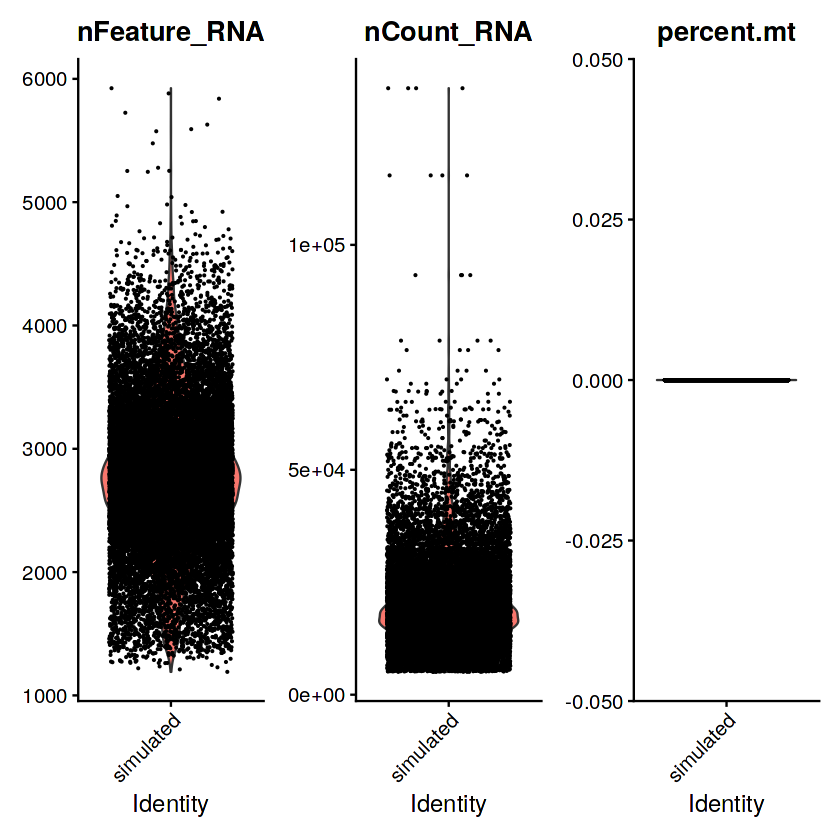

When using repel, set xnudge and ynudge to 0 for optimal results



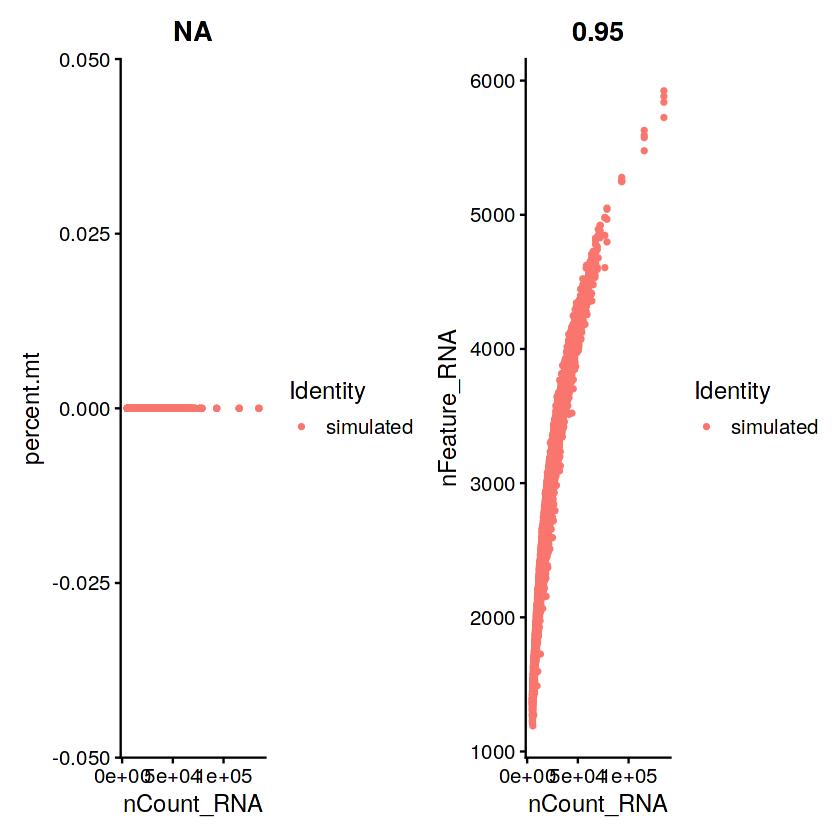

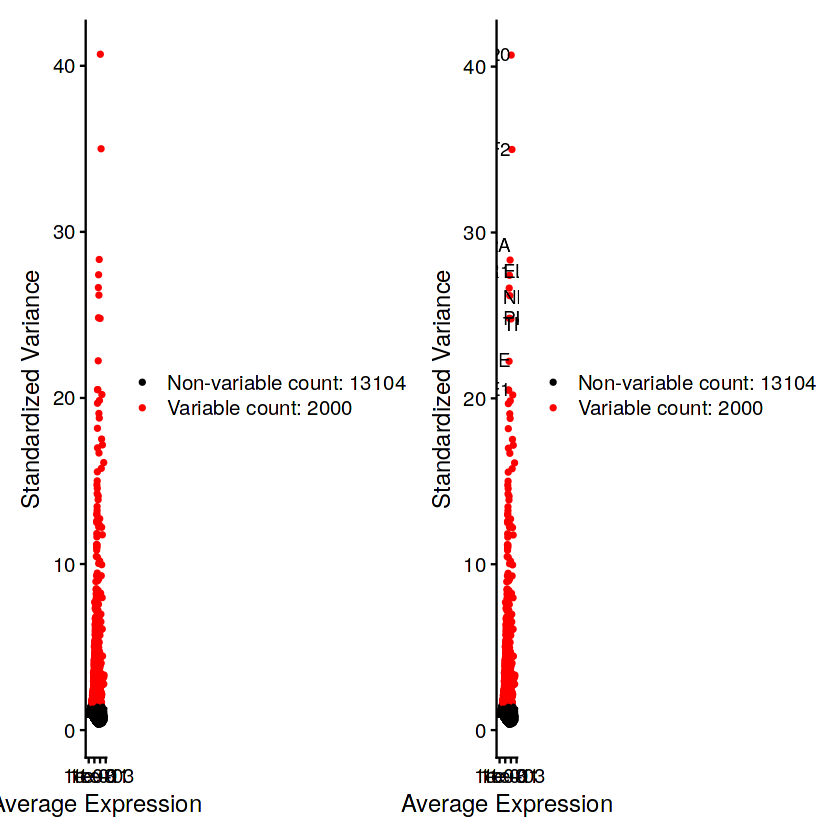

In [33]:
rownames(sim_result$count_matrix)=make.names(rownames(sim_result$count_matrix))
colnames(sim_result$count_matrix)=make.names(colnames(sim_result$count_matrix))

sObject <- CreateSeuratObject(counts = sim_result$count_matrix, project = "simulated", min.cells = 0, min.features = 200)
sObject[["percent.mt"]] <- PercentageFeatureSet(sObject, pattern = "^MT-")

VlnPlot(sObject, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(sObject, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(sObject, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2
sObject <- NormalizeData(sObject, normalization.method = "LogNormalize", scale.factor = 10000)
sObject <- FindVariableFeatures(sObject, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(sObject), 10)
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(sObject)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

Centering and scaling data matrix

PC_ 1 
Positive:  MAP2K6, KYAT1, PIGK, SHOC2, PGAP1, PNPT1, OAT, MMUT, APOBEC3G, ESYT1 
	   PIP4K2C, IL4I1, MMAA, GPAA1, RIMKLA, REXO2, HMGA1, ASRGL1, PCBD1, PIN1 
	   PPP1CB, GLUL, EP300, PYCR1, MRAS, SLIRP, PPP1CA, HGD, ING2, PLAUR 
Negative:  RAP1GAP2, DAZAP2, LMBRD1, NSD1, SRRM1, VAMP5, IRS2, S100A13, UBE3D, UCHL1 
	   PDK2, MAPK3, S1PR1, DKC1, SDK2, RBBP6, AGTPBP1, FAF2, CIT, RXRA 
	   DPY19L3, PTPRN2, RORA, SREBF1, CORO1A, HSF1, ACACB, PRKAG2, CYBA, PCK2 
PC_ 2 
Positive:  PGAP1, SHOC2, MMUT, PIP4K2C, PNPT1, OAT, MAP2K6, KYAT1, APOBEC3G, MMAA 
	   PIGK, ESYT1, RIMKLA, EP300, PPP1CB, PIN1, HGD, ING2, E2F1, PYCR1 
	   PLAUR, PCBD1, ASRGL1, HMGA1, GPAA1, SP1, GLUL, MRAS, SLIRP, PPP1CA 
Negative:  AURKB, NFATC2, UBE2D1, ANP32A, GAPDH, MIR22HG, HMGB2, NDUFB6, SERPINE1, SEPTIN11 
	   DESI1, TAB2, VIM, BNIP3, DDX17, RPS4X, NEB, SPRY1, AK4, XRCC6 
	   PNOC, IPO7, IFT88, HSDL2, B3GNT3, DUSP5, RPL19, GM2A, TBP, VEGFA 
PC_ 3 
Positive:  AURKB, NFATC2, GAPD

PC_ 1 
Positive:  MAP2K6, KYAT1, PIGK, SHOC2, PGAP1 
Negative:  RAP1GAP2, DAZAP2, LMBRD1, NSD1, SRRM1 
PC_ 2 
Positive:  PGAP1, SHOC2, MMUT, PIP4K2C, PNPT1 
Negative:  AURKB, NFATC2, UBE2D1, ANP32A, GAPDH 
PC_ 3 
Positive:  AURKB, NFATC2, GAPDH, MIR22HG, NDUFB6 
Negative:  ANP32A, UBE2D1, HMGB2, B3GNT3, TBP 
PC_ 4 
Positive:  ANPEP, UBE2D1, ERBB3, B3GNT3, TBP 
Negative:  MPI, RBMS2, DUS1L, PTPN23, NUTF2 
PC_ 5 
Positive:  GLB1L, SNAPIN, GPRC5D, FANCC, HMGA1P4 
Negative:  B3GAT2, RABGGTA, PANK3, SNX33, FKBP9 


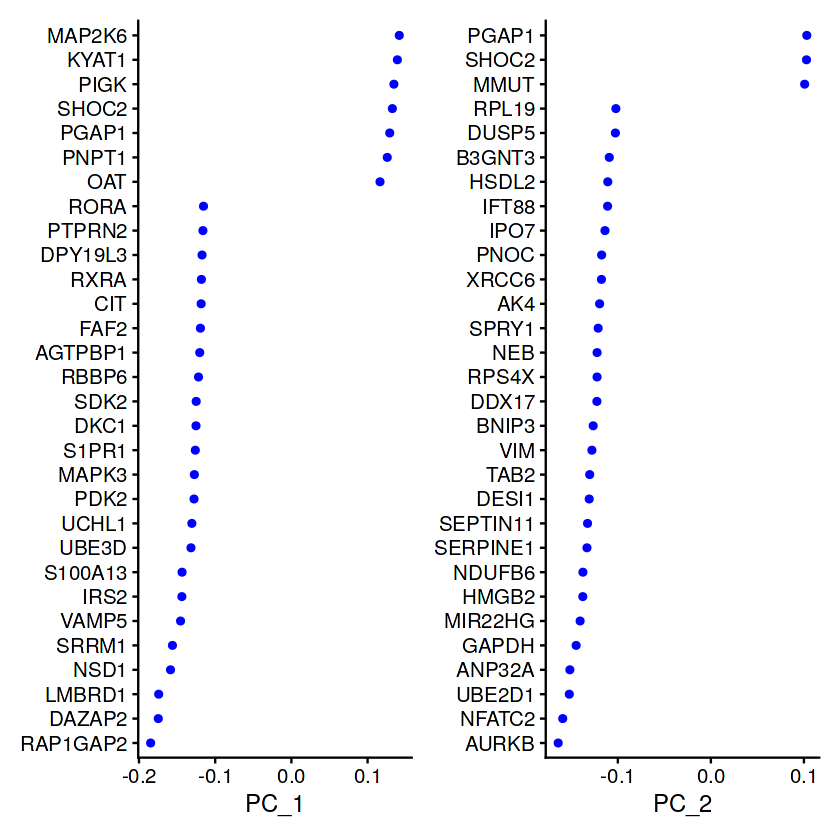

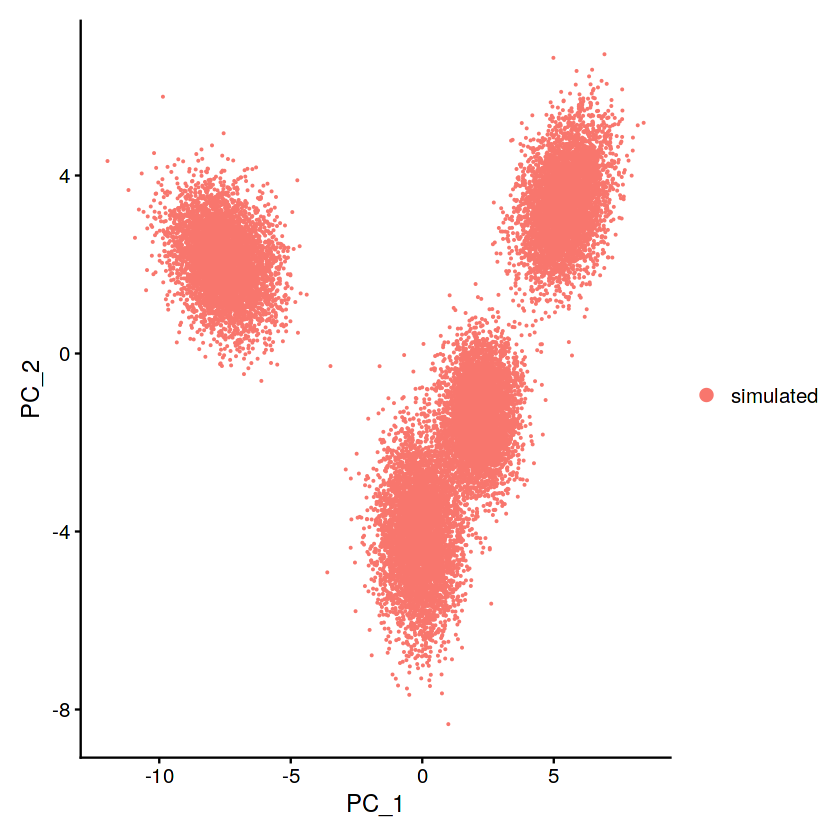

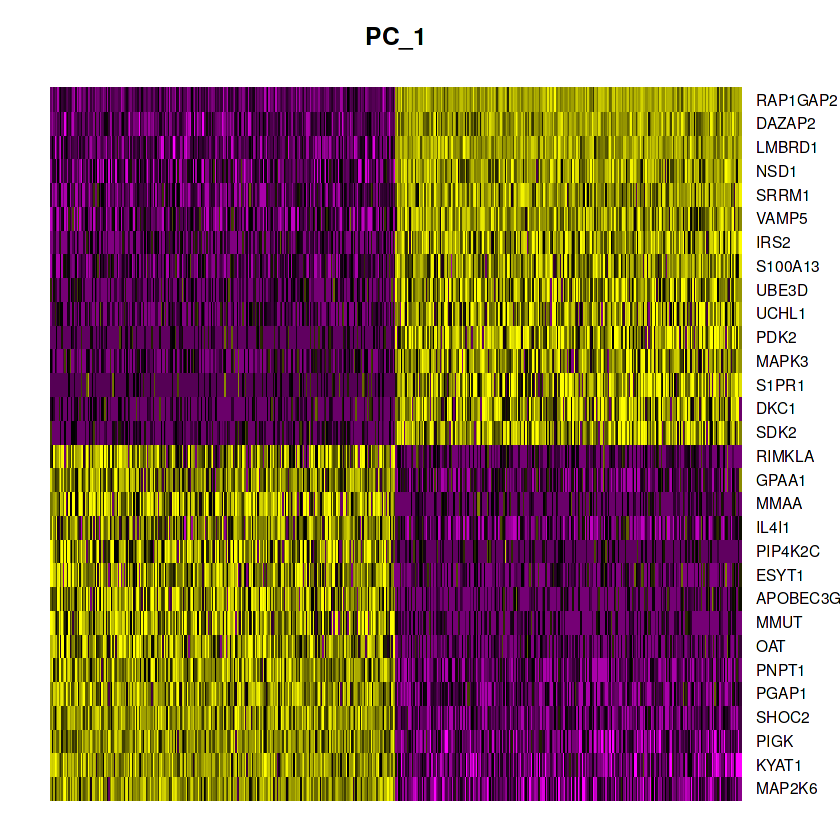

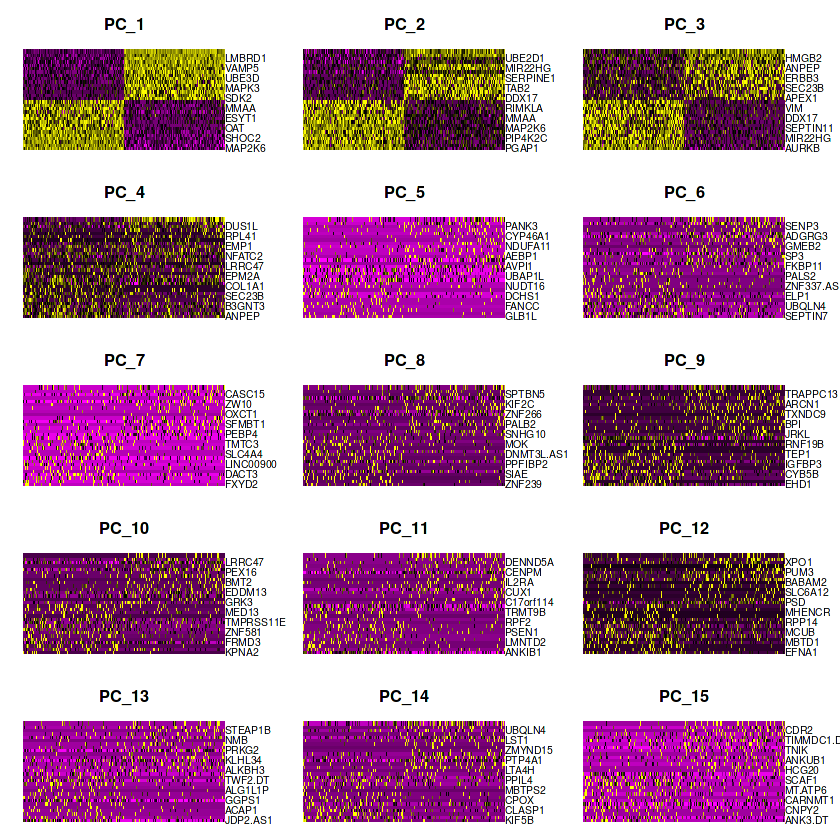

In [34]:
#all.genes <- rownames(sObject)
sObject <- ScaleData(sObject)

sObject <- RunPCA(sObject, features = VariableFeatures(object = sObject))
print(sObject[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(sObject, dims = 1:2, reduction = "pca")
DimPlot(sObject, reduction = "pca")
DimHeatmap(sObject, dims = 1, cells = 500, balanced = TRUE)
DimHeatmap(sObject, dims = 1:15, cells = 500, balanced = TRUE)

In [35]:
sObject <- FindNeighbors(sObject, dims = 1:5, verbose = FALSE)
sObject <- FindClusters(sObject, resolution = 1, verbose = FALSE)
head(Idents(sObject), 5)

sObject <- RunUMAP(sObject, dims = 1:10, verbose = FALSE)

wildtype.Cell1 wildtype.Cell2 wildtype.Cell3 wildtype.Cell4 wildtype.Cell5 
             5              8              3              5              5 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


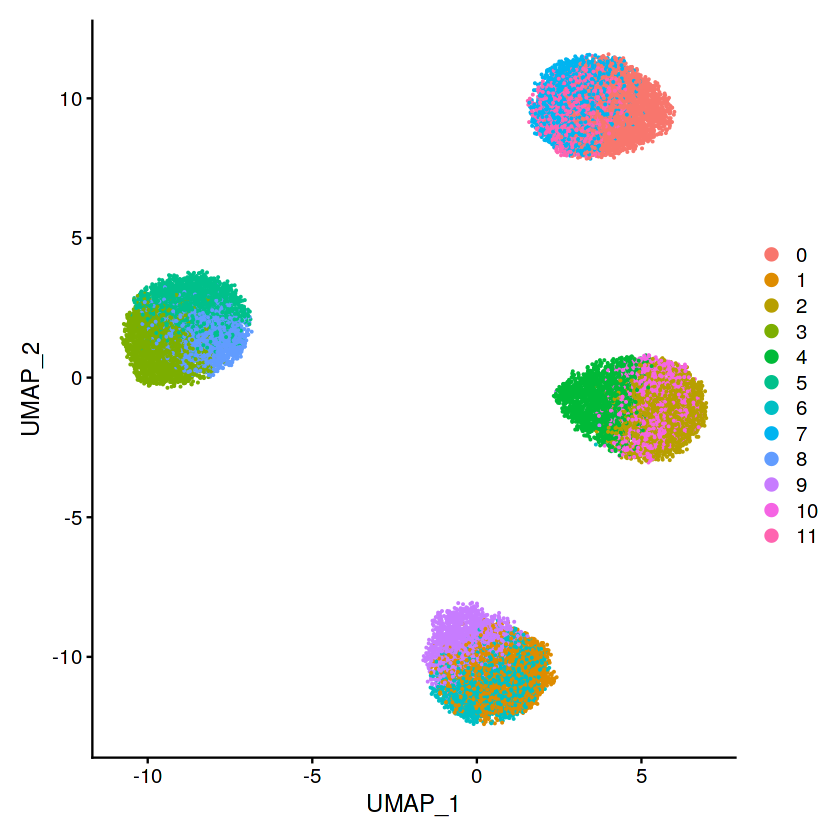

In [36]:
DimPlot(sObject)

In [37]:
condition_vector = unlist(lapply(stringr::str_split(colnames(sim_result$count_matrix),"\\."), function(x) {return(x[[1]])}))

In [38]:
sObject$simulated_condition <- factor(condition_vector, levels=states)

In [39]:
head(unique(condition_vector))

[1] "wildtype" "stage1"   "stage2"   "stage3"

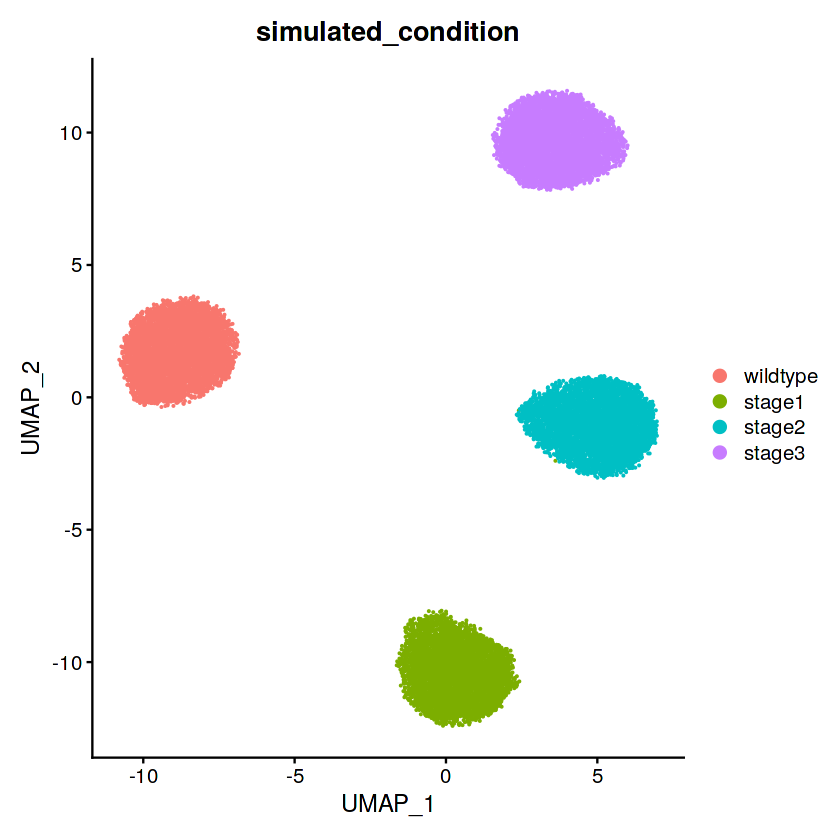

In [40]:
DimPlot(sObject, group.by = "simulated_condition")

In [41]:
sObject

An object of class Seurat 
15104 features across 21676 samples within 1 assay 
Active assay: RNA (15104 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [42]:
saveRDS(sObject, file = "simulated_scdata_seurat.rds")

In [43]:
library(sceasy)
library(reticulate)

Loading required package: reticulate



In [44]:
use_condaenv('seurat_scanpy11',conda="/mnt/extproj/projekte/bartelt/software/miniconda3/condabin/conda")
loompy <- reticulate::import('loompy')

In [45]:
sceasy::convertFormat(sObject, from="seurat", to="anndata",
                       outFile='simulated_scdata_scanpy.h5ad')

Warning message in .regularise_df(obj@meta.data, drop_single_values = drop_single_values):
“Dropping single category variables:orig.ident, percent.mt”


AnnData object with n_obs × n_vars = 21676 × 15104
    obs: 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.1', 'seurat_clusters', 'simulated_condition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'

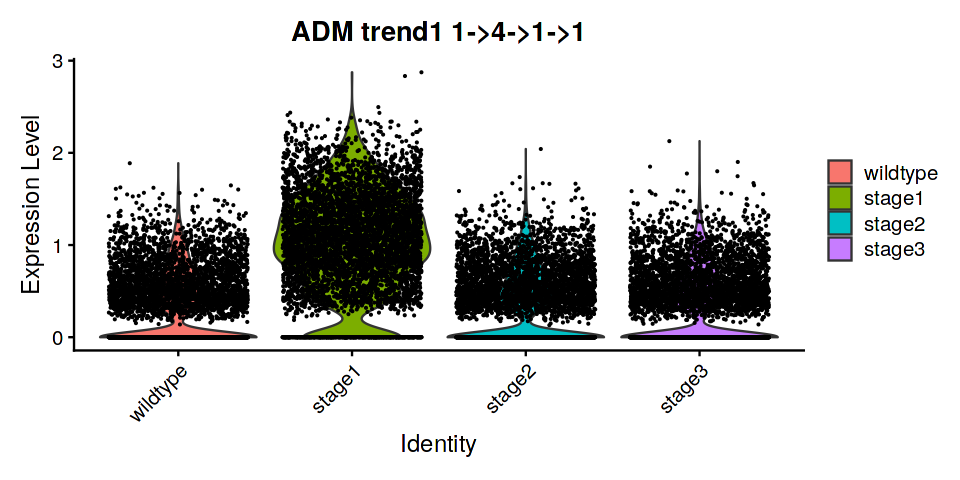

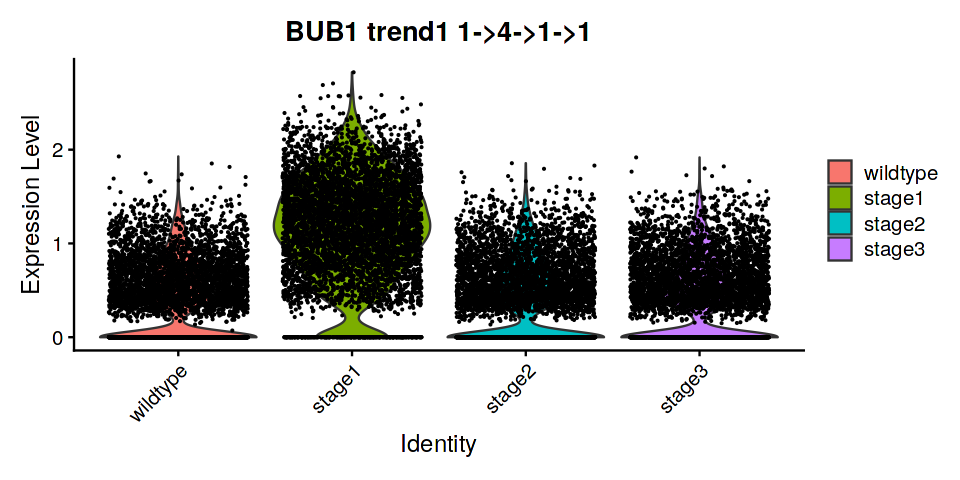

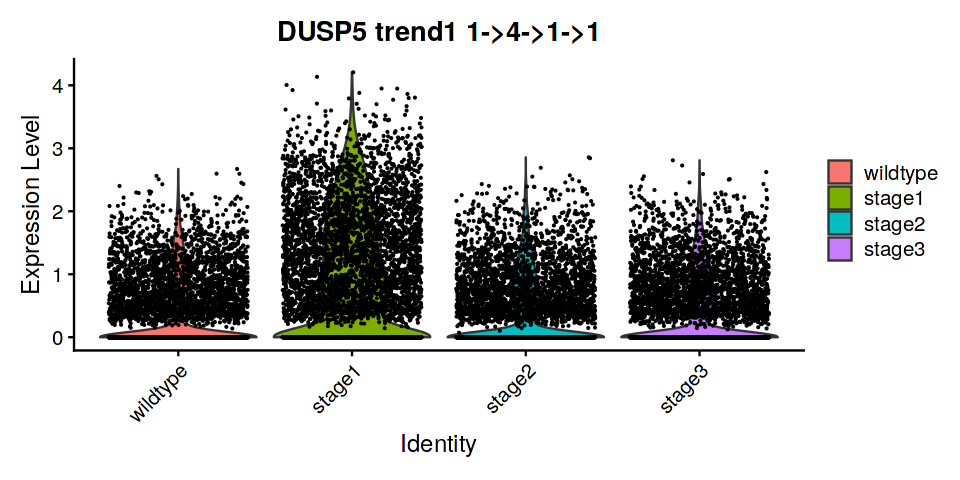

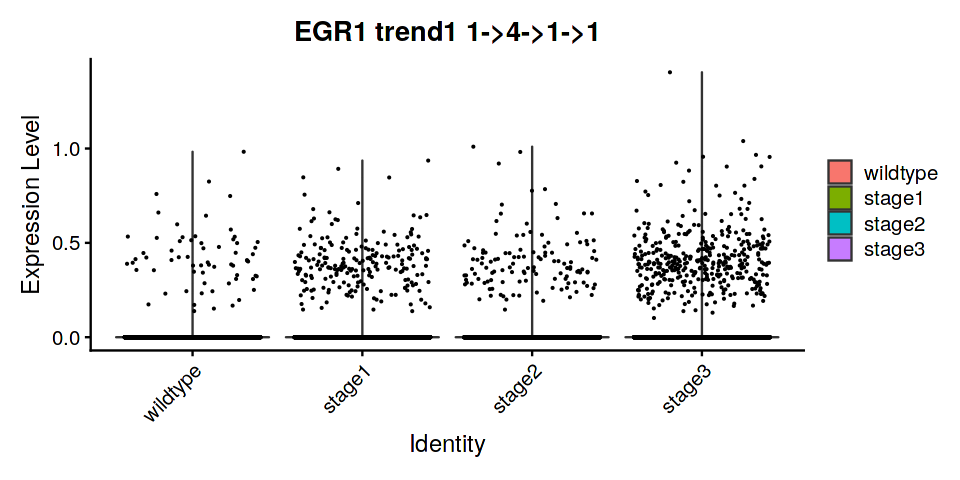

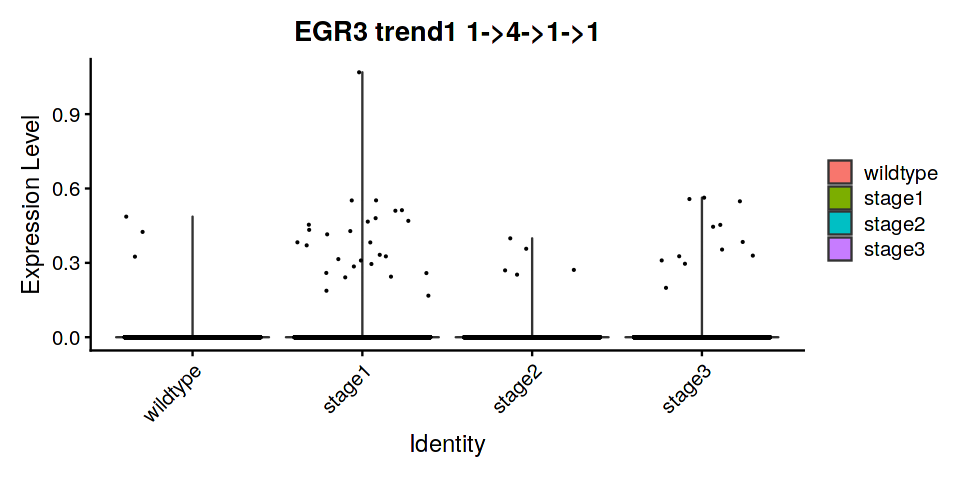

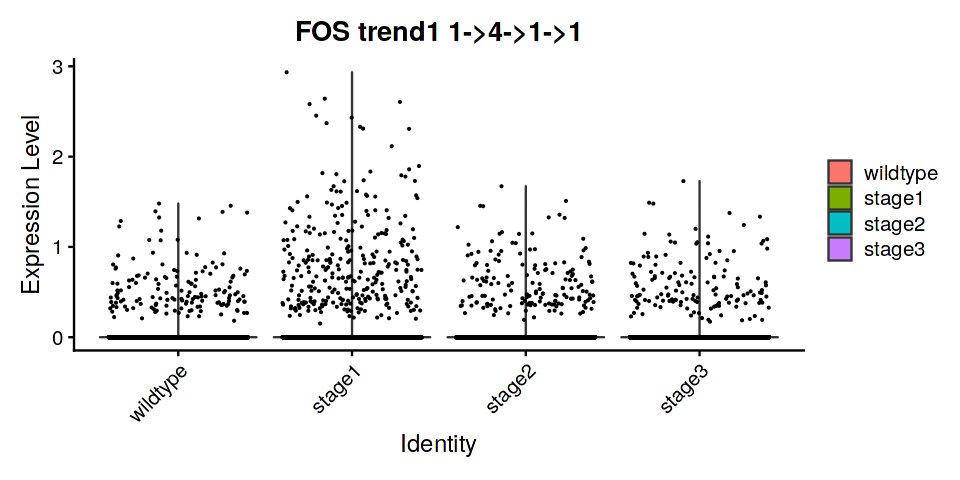

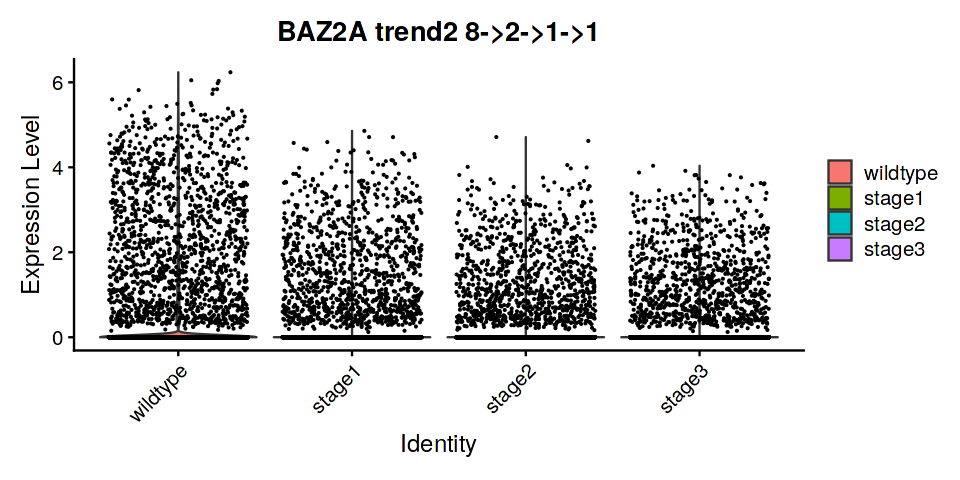

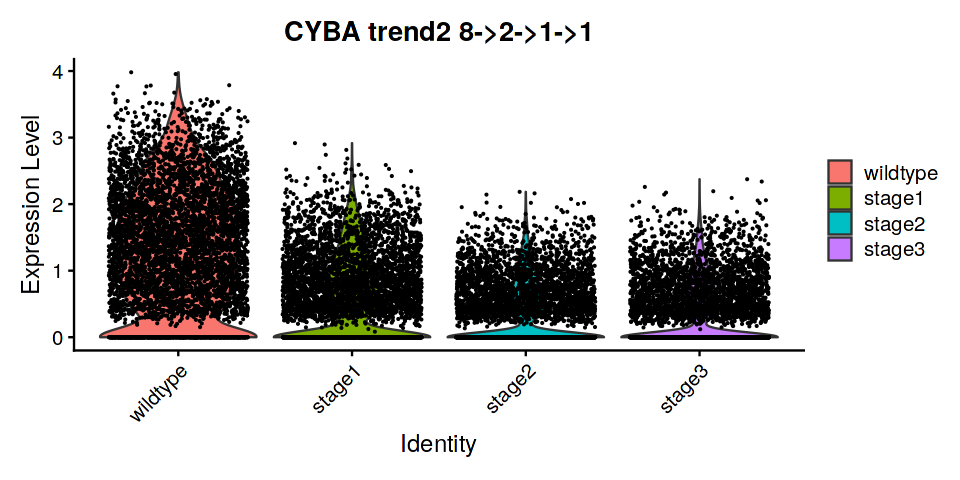

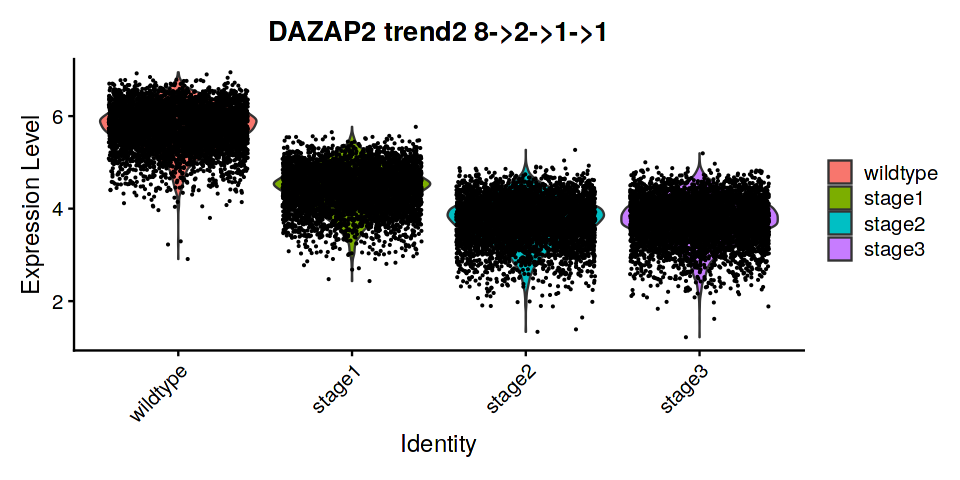

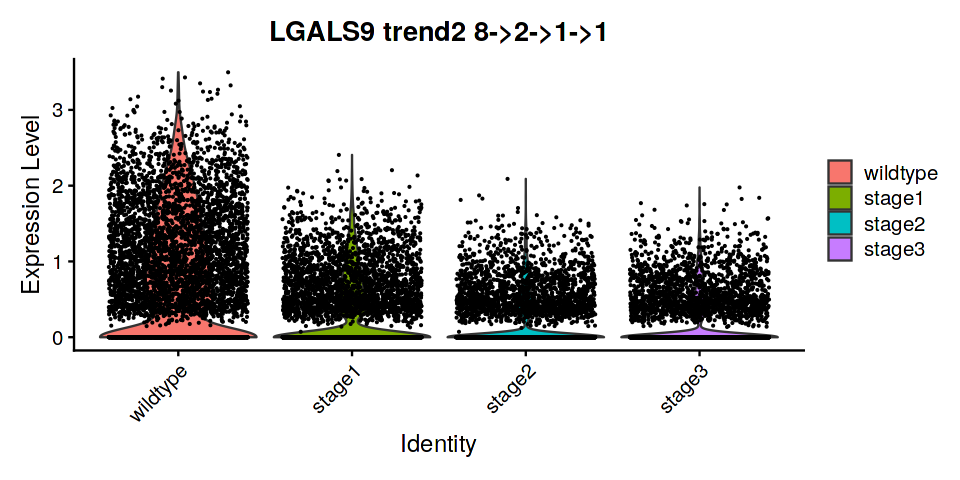

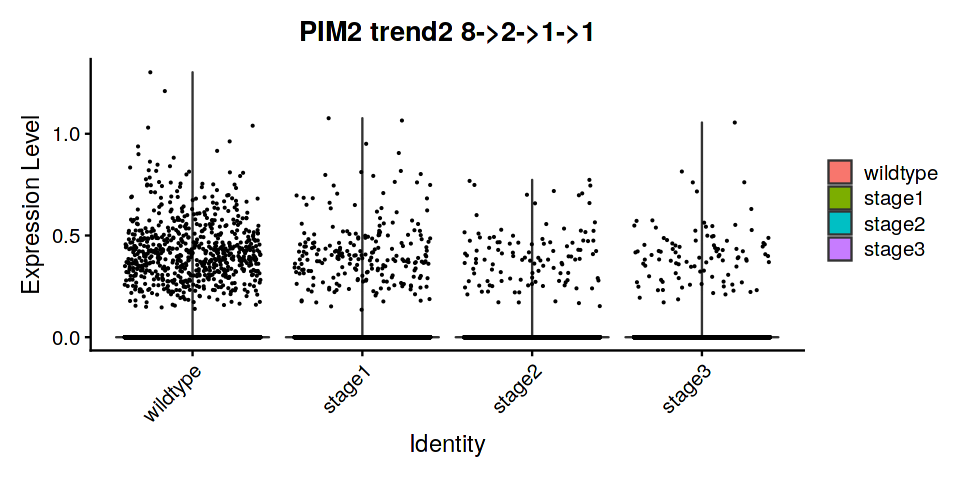

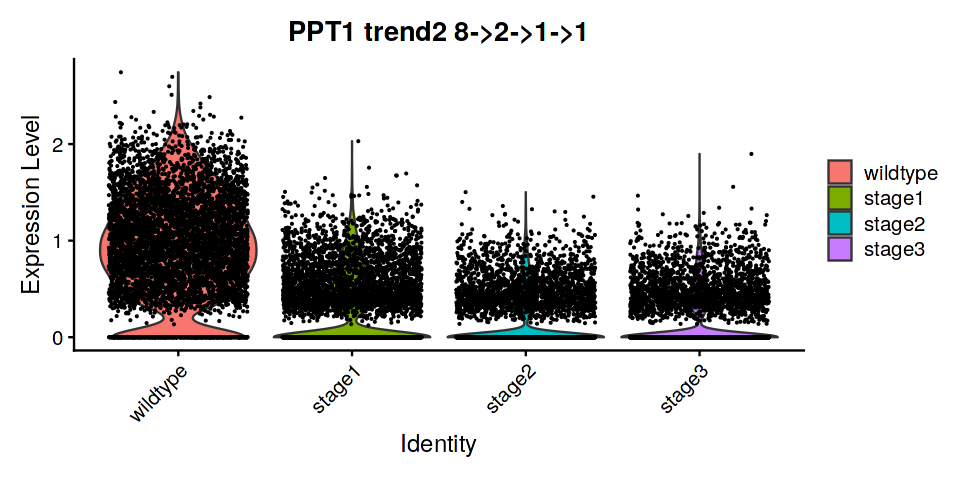

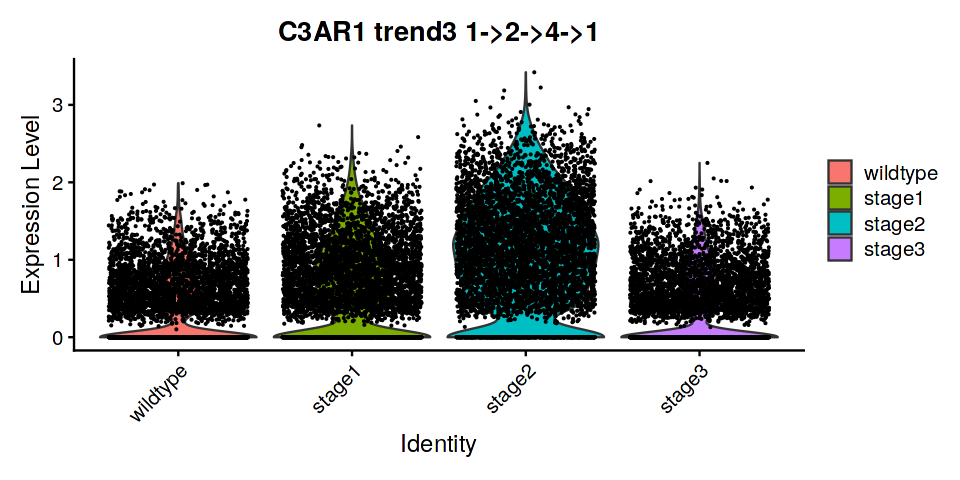

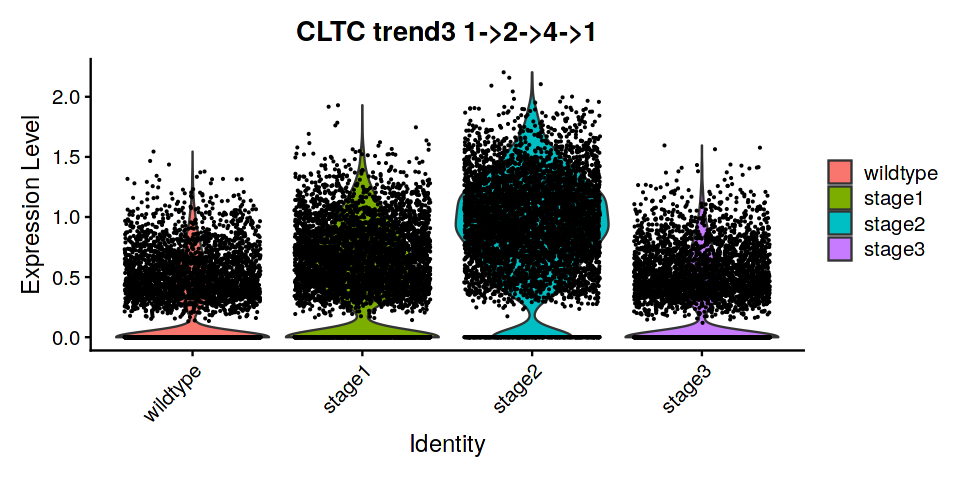

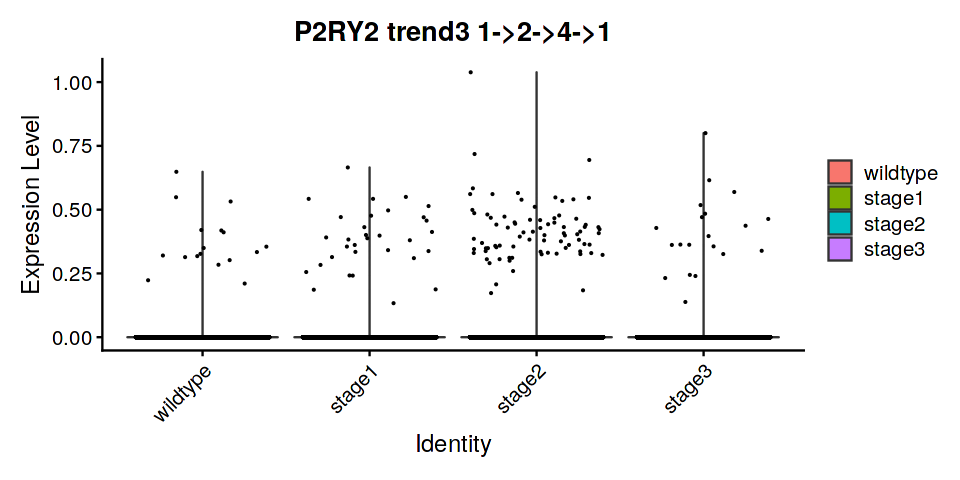

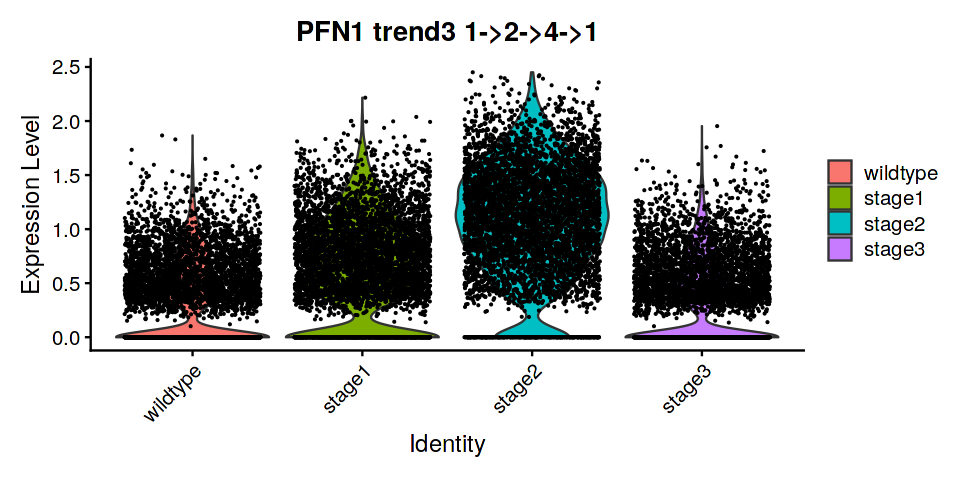

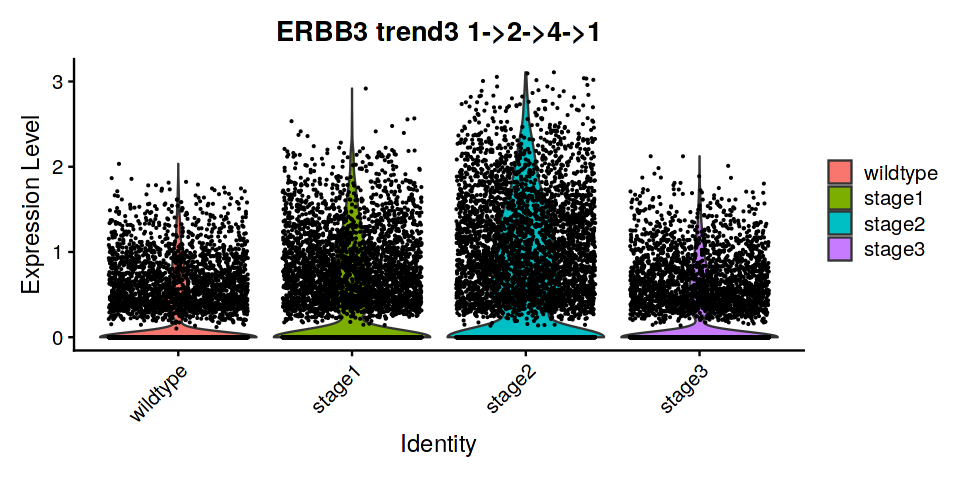

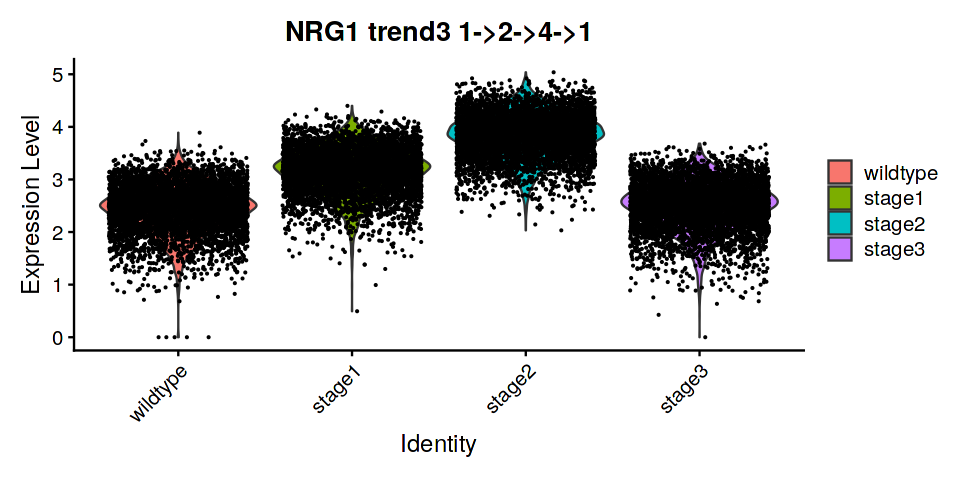

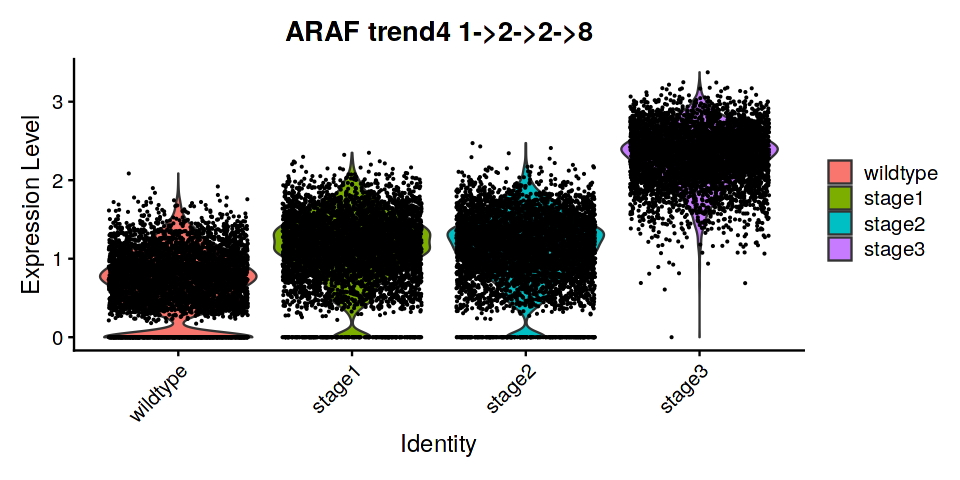

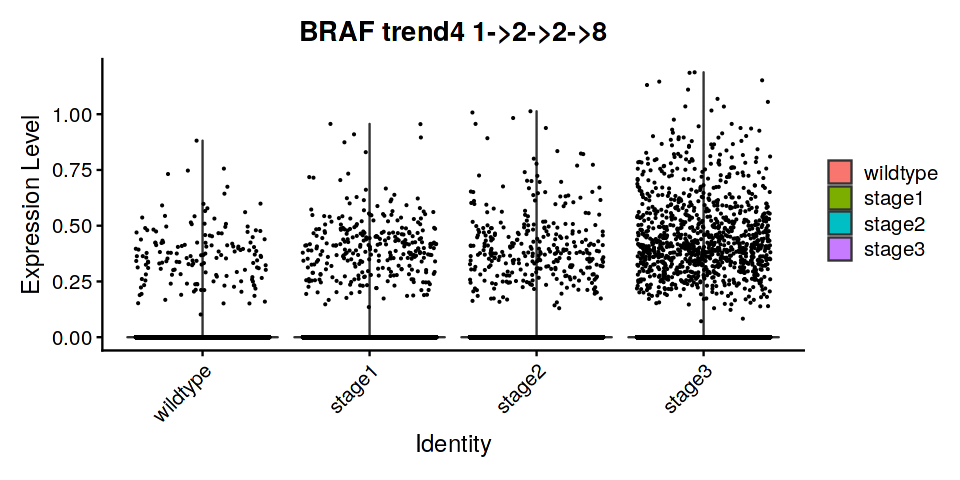

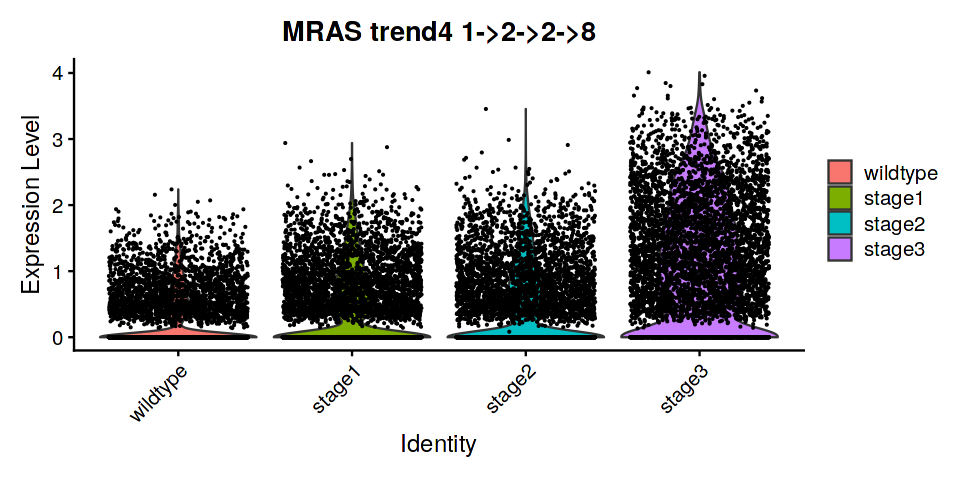

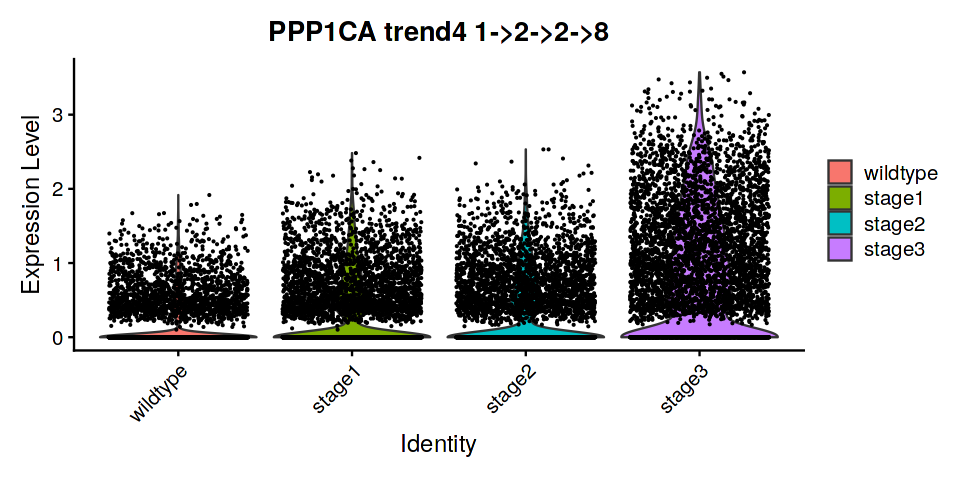

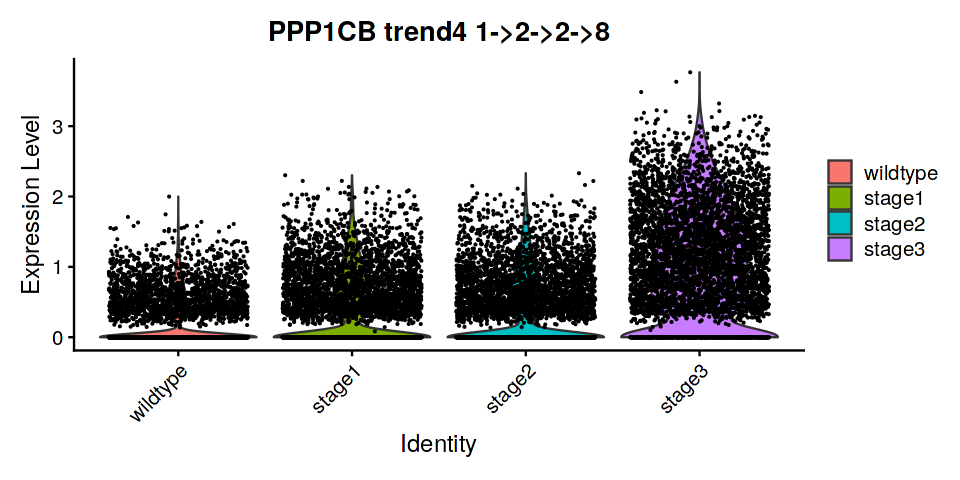

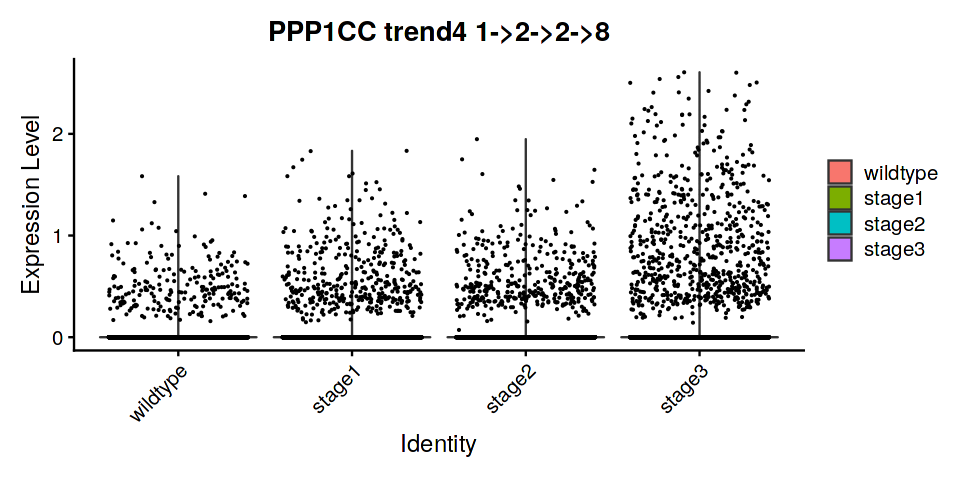

In [46]:
options(repr.plot.width = 8, repr.plot.height = 4)

for (trendindex in 1:length(trends))
{
    trend = names(trends)[trendindex]
    trendFactors = trends[[trend]]
    
    plotnamesuffix = paste(trend, paste(trendFactors, sep="->", collapse = "->"))

    for (gene in head(trend2genes[[trend]]))
    {
        gene = make.names(gene)
        p=VlnPlot(sObject, gene, group.by="simulated_condition") + ggtitle(paste(gene, plotnamesuffix))
        plot(p)

    }

}

In [47]:
changes_df[changes_df$gene == "TP53",]

wildtype stage1 stage2 stage3
X.125 1        4      1      1     
X.237 8        2      1      1     
X.324 1        2      4      1     
X.413 1        2      2      8     
      geneset                                                    trend 
X.125 IIZUKA_LIVER_CANCER_EARLY_RECURRENCE                       trend1
X.237 TSUDA_ALVEOLAR_SOFT_PART_SARCOMA                           trend2
X.324 KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS trend3
X.413 REACTOME_PI5P_REGULATES_TP53_ACETYLATION                   trend4
      element_type gene
X.125 tf           TP53
X.237 tf           TP53
X.324 tf           TP53
X.413 gene         TP53

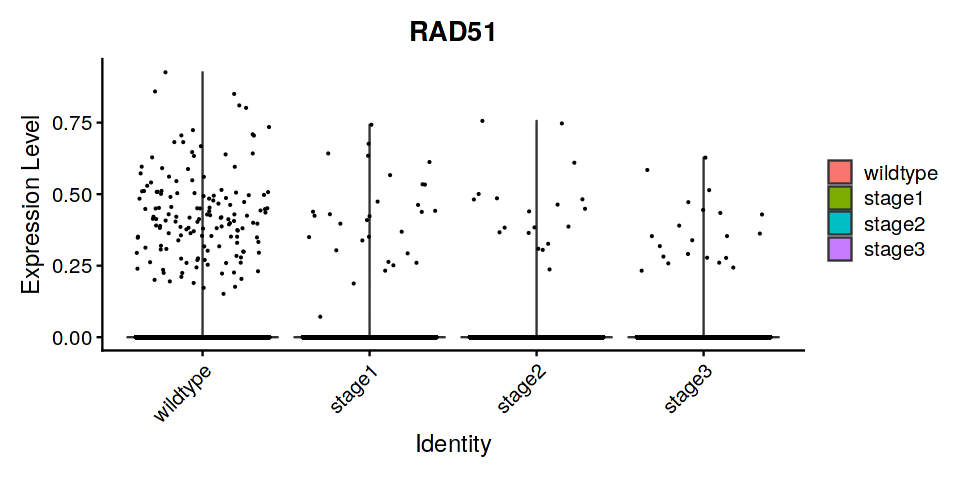

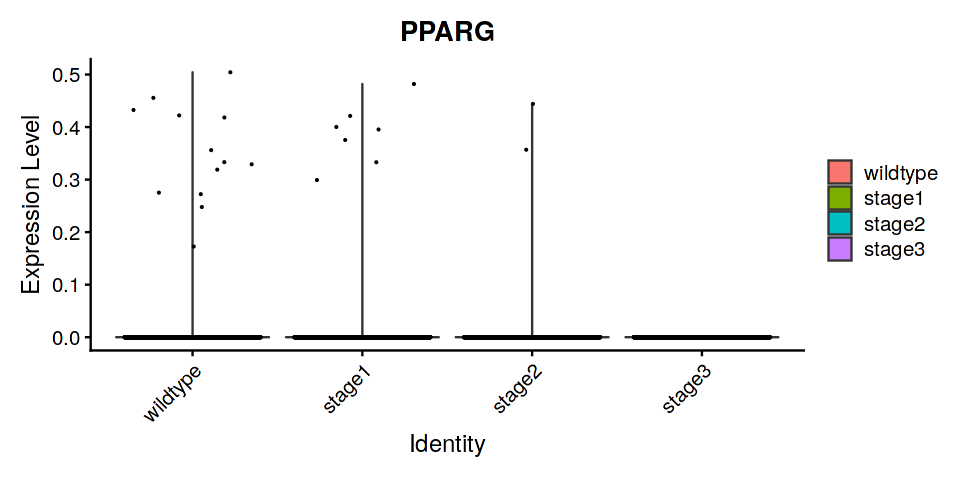

[1] "Missing gene TWIST1"


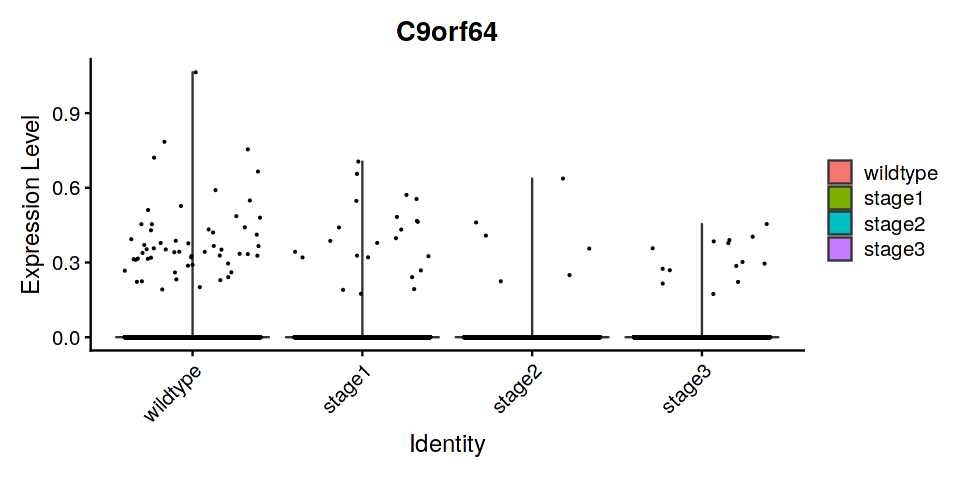

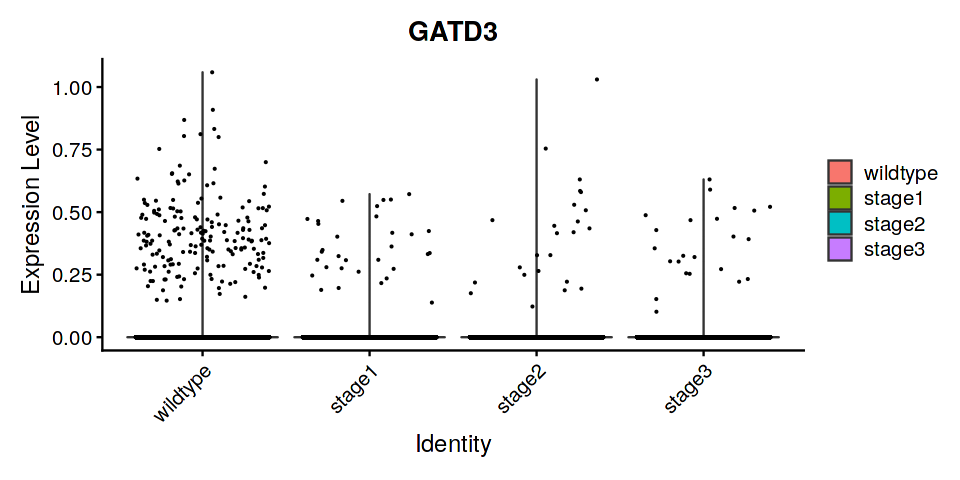

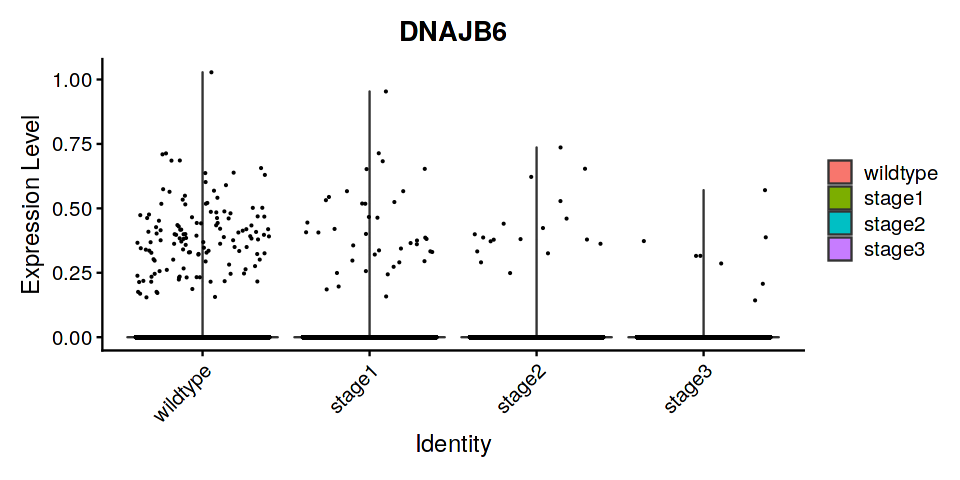

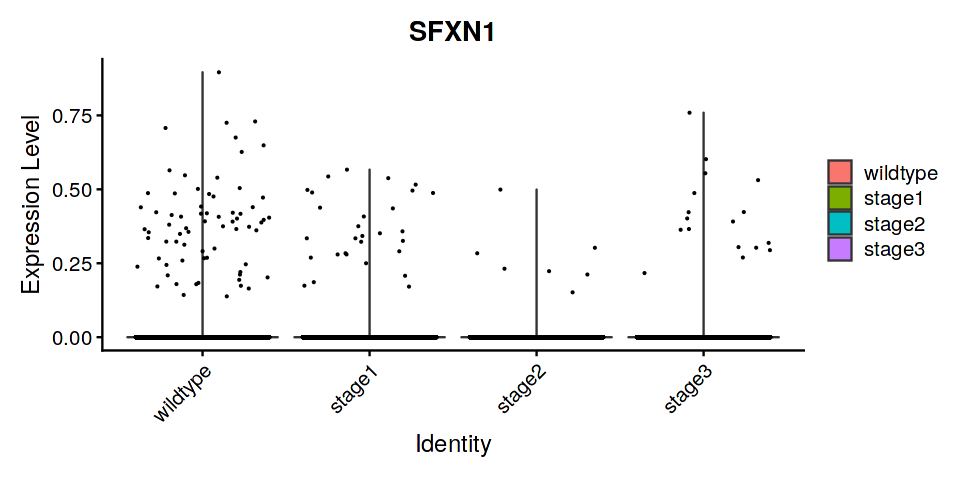

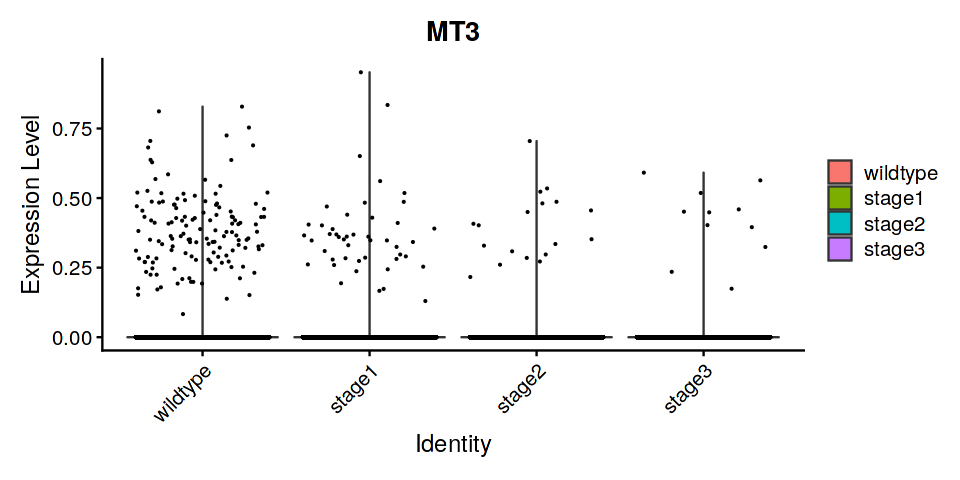

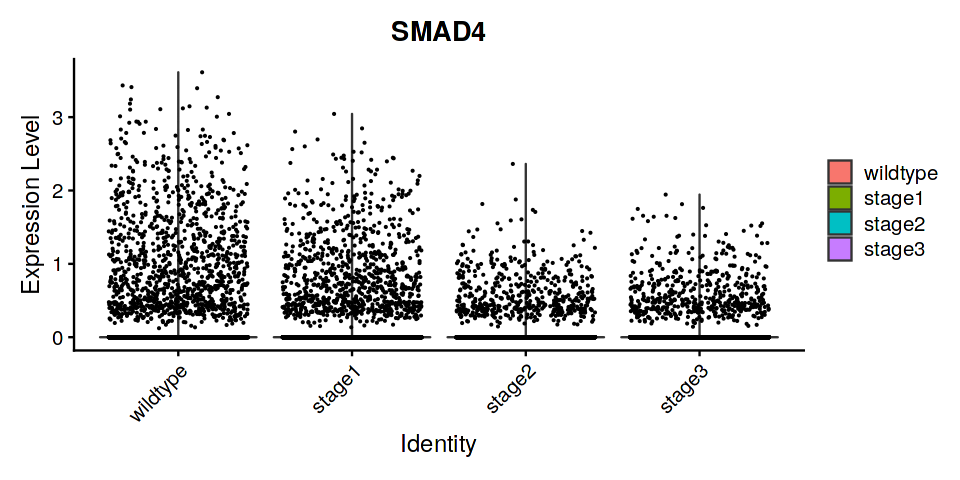

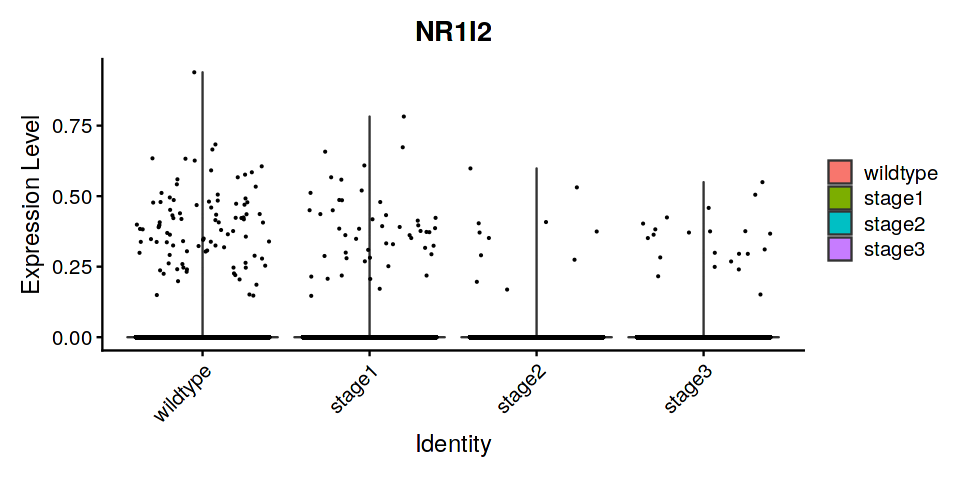

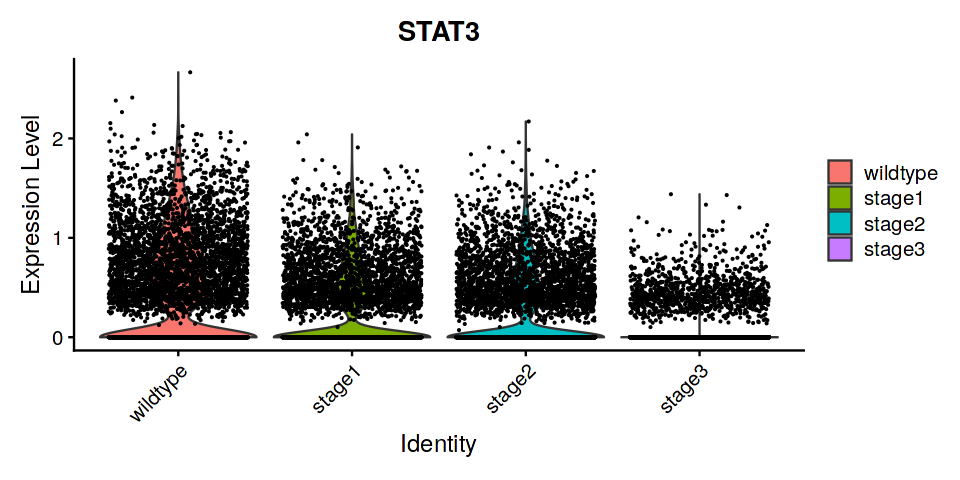

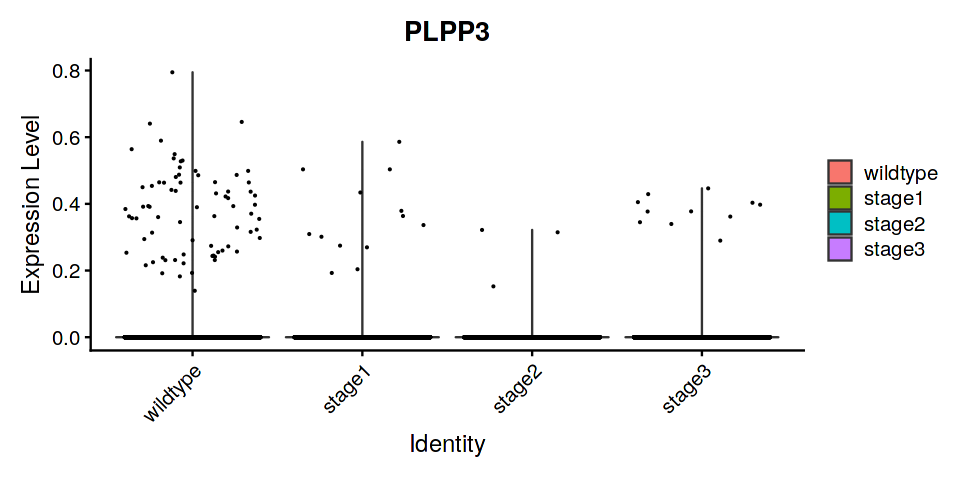

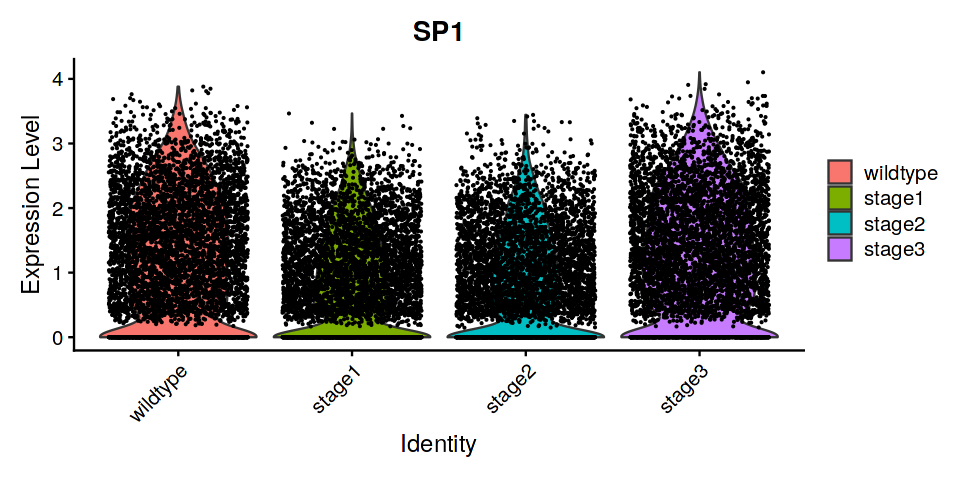

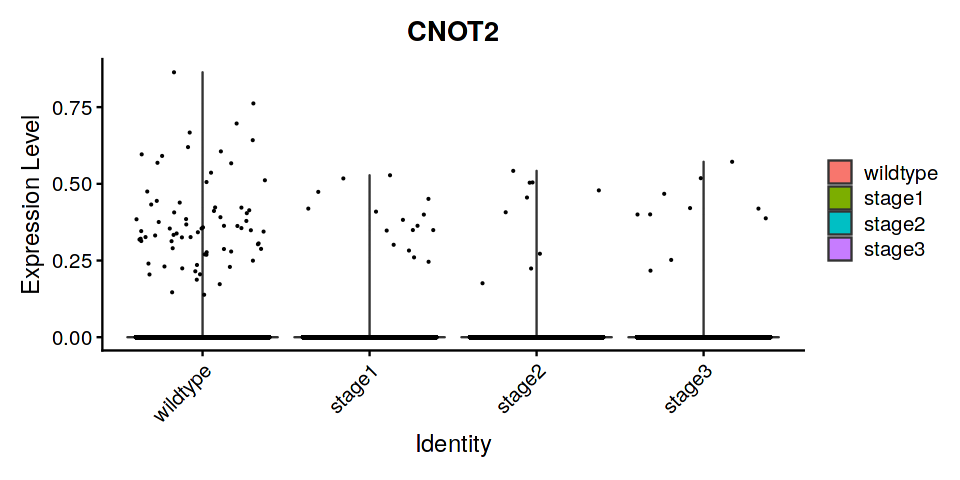

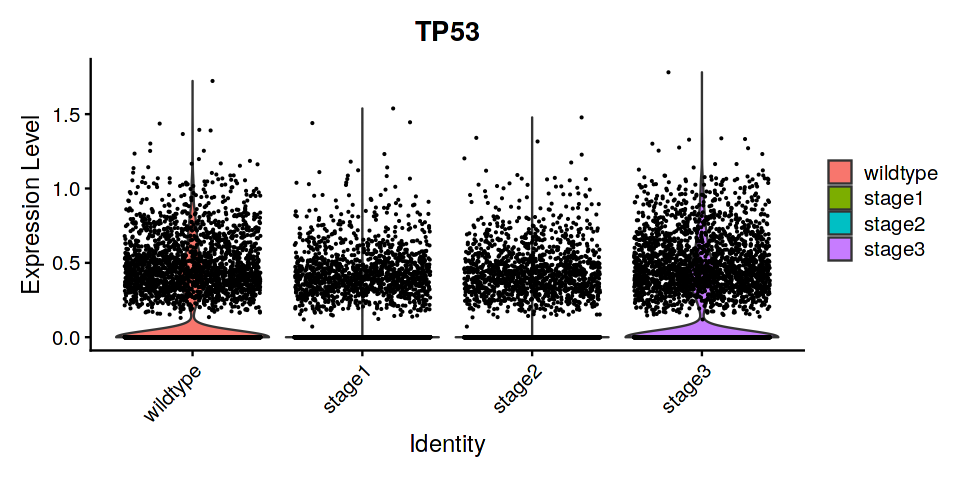

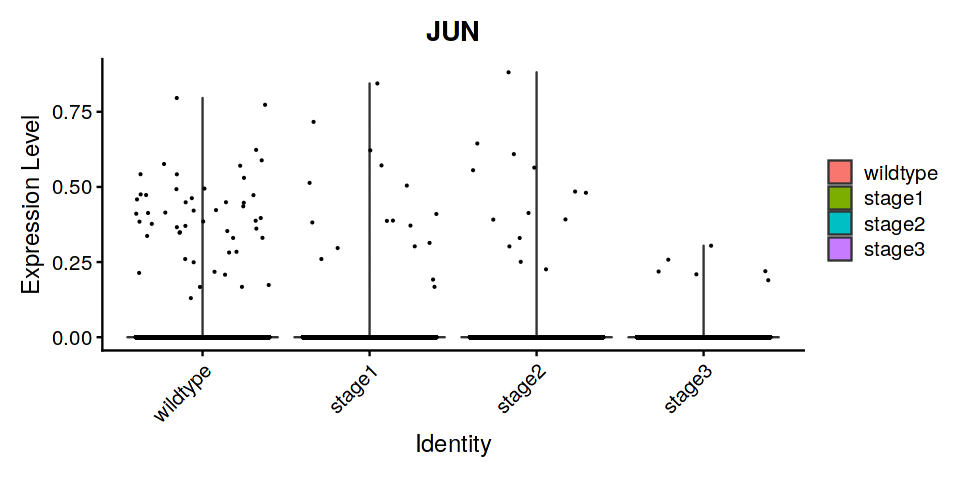

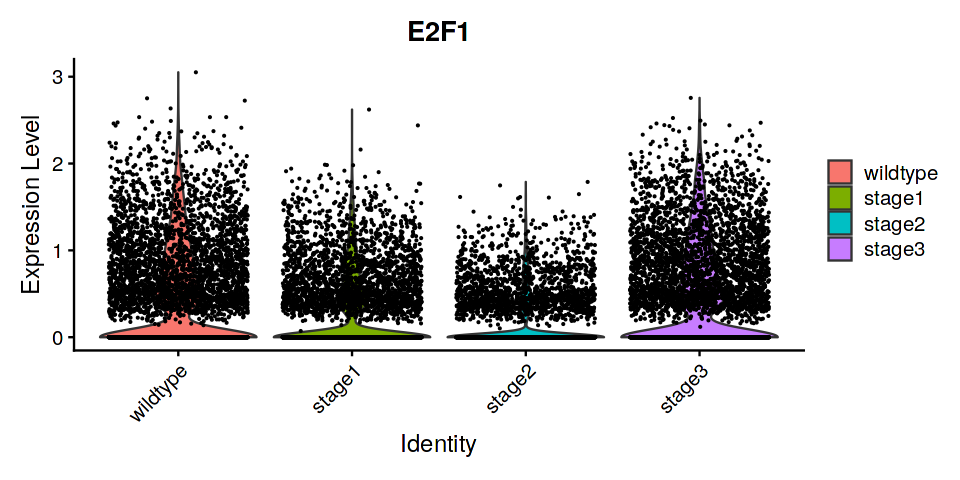

In [48]:
options(repr.plot.width = 8, repr.plot.height = 4)

for (gene in c('RAD51', 'PPARG', 'C9orf64', 'TWIST1', 'GATD3', 'DNAJB6', 'SFXN1', 'MT3', 'SMAD4', 'NR1I2', 'STAT3', 'PLPP3', 'SP1', 'CNOT2', 'TP53', 'JUN', 'E2F1'))
{
    if (!(gene %in% rownames(sObject)))
    {
        print(paste("Missing gene", gene))
        next
    }
    p=VlnPlot(sObject, gene, group.by="simulated_condition") + ggtitle(gene)
    plot(p)

}

In [49]:
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: SUSE Linux Enterprise Server 15 SP5

Matrix products: default
BLAS/LAPACK: /usr/lib64/openblas-pthreads/libopenblas.so.0;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.utf8       LC_NUMERIC=C             
 [3] LC_TIME=en_US.utf8        LC_COLLATE=en_US.utf8    
 [5] LC_MONETARY=en_US.utf8    LC_MESSAGES=en_US.utf8   
 [7] LC_PAPER=en_US.utf8       LC_NAME=C                
 [9] LC_ADDRESS=C              LC_TELEPHONE=C           
[11] LC_MEASUREMENT=en_US.utf8 LC_IDENTIFICATION=C      

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sceasy_0.0.7       reticulate_1.34.0  tftargets_1.3      biomaRt_2.56.0    
 [5] ggplot2_3.4.2      stringr_1.5.0      qusage_2.34.0      limma_3.56.1      
 [9] SeuratObject_4.1.3 Seurat_4.3.0       dplyr_1.1.2        SPARSim_0.9.5    

In [50]:
format(Sys.time(), "%H:%M:%S")

[1] "10:08:19"

In [10]:
library("Seurat")
library("ggplot2")

In [2]:
sObject = readRDS(file = "simulated_scdata_seurat.rds")

In [5]:
changes_df = read.table(file = "simulated_changes_detail.tsv",sep="\t", header = TRUE)
changes_df

wildtype stage1 stage2 stage3
1   1        4      1      1     
2   1        4      1      1     
3   1        4      1      1     
4   1        4      1      1     
5   1        4      1      1     
6   1        4      1      1     
7   1        4      1      1     
8   1        4      1      1     
9   1        4      1      1     
10  1        4      1      1     
11  1        4      1      1     
12  1        4      1      1     
13  1        4      1      1     
14  1        4      1      1     
15  1        4      1      1     
16  1        4      1      1     
17  1        4      1      1     
18  1        4      1      1     
19  1        4      1      1     
20  1        4      1      1     
21  1        4      1      1     
22  1        4      1      1     
23  1        4      1      1     
24  1        4      1      1     
25  1        4      1      1     
26  1        4      1      1     
27  1        4      1      1     
28  1        4      1      1     
29  1        4      1      1     
30  1        4      1      1     
⋮   ⋮        ⋮      ⋮      ⋮     
390 1        2      2      8     
391 1        2      2      8     
392 1        2      2      8     
393 1        2      2      8     
394 1        2      2      8     
395 1        2      2      8     
396 1        2      2      8     
397 1        2      2      8     
398 1        2      2      8     
399 1        2      2      8     
400 1        2      2      8     
401 1        2      2      8     
402 1        2      2      8     
403 1        2      2      8     
404 1        2      2      8     
405 1        2      2      8     
406 1        2      2      8     
407 1        2      2      8     
408 1        2      2      8     
409 1        2      2      8     
410 1        2      2      8     
411 1        2      2      8     
412 1        2      2      8     
413 1        2      2      8     
414 1        2      2      8     
415 1        2      2      8     
416 1        2      2      8     
417 1        2      2      8     
418 1        2      2      8     
419 1        2      2      8     
    geneset                                        trend  element_type gene    
1   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         ADM     
2   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         BUB1    
3   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         DUSP5   
4   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         EGR1    
5   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         EGR3    
6   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         FOS     
7   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         GNS     
8   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         HSDL2   
9   AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         JUN     
10  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         KLF6    
11  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         MIS18BP1
12  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         NDUFB6  
13  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         TIMM44  
14  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         TUFT1   
15  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         UNC93B1 
16  AMIT_EGF_RESPONSE_40_MCF10A                    trend1 gene         ZFP36   
17  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend1 gene         AIMP2   
18  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend1 gene         CDKN1B  
19  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend1 gene         CTSL    
20  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend1 gene         GARS1   
21  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend1 gene         GOLGB1  
22  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend1 gene         ID2     
23  CAFFAREL_RESPONSE_TO_THC_8HR_5_UP              trend

Warning message:
“Scaling data with a low number of groups may produce misleading results”


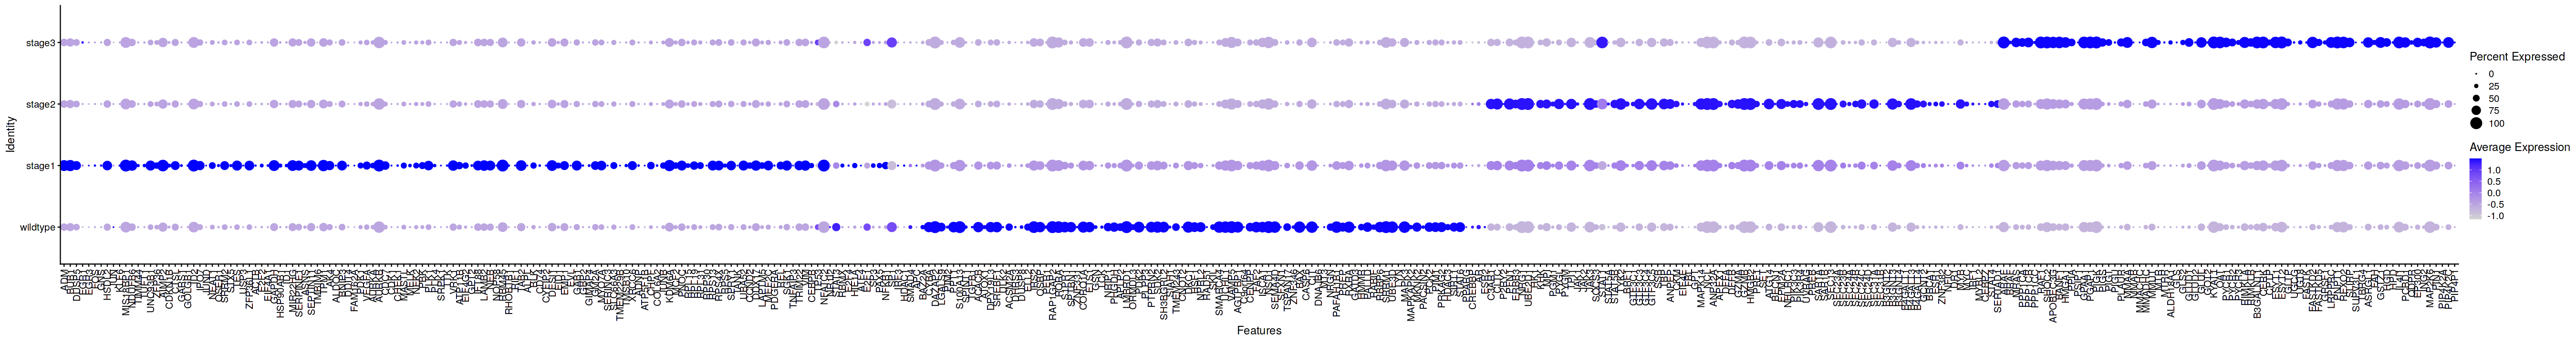

In [13]:
options(repr.plot.width = 45, repr.plot.height = 6)

p=DotPlot(sObject, features = intersect(changes_df$gene, rownames(sObject)), group.by = "simulated_condition")
p + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [19]:
p$data[ (p$data$avg.exp < 0.001) & (p$data$avg.exp < 0.001), ]

avg.exp      pct.exp    features.plot id       avg.exp.scaled
JUN     0.0002918760 0.11072154 JUN           stage3   -0.9595484    
EVL     0.0003229107 0.05536077 EVL           stage3   -0.7931569    
TNFAIP3 0.0002750878 0.05536077 TNFAIP3       stage3   -0.8209186    
PPARG   0.0000000000 0.00000000 PPARG         stage3   -0.9950628    
HK1     0.0001565230 0.05536077 HK1           stage3   -0.8722151    
JAK2    0.0003004254 0.07381436 JAK2          stage3   -0.8008947    
SEC31B  0.0004641091 0.05536077 SEC31B        stage3   -1.0757610    
EGR32   0.0003372796 0.09226795 EGR3          stage2   -0.6923107    
SRPK12  0.0003635559 0.07381436 SRPK1         stage2   -0.7709997    
PLPP32  0.0001686694 0.05536077 PLPP3         stage2   -0.6857154    
SFXN12  0.0004131992 0.12917512 SFXN1         stage2   -0.8981934    
PPARG2  0.0001822823 0.03690718 PPARG         stage2   -0.5944214    
EGR33   0.0002841800 0.05536077 EGR3          wildtype -0.7426960    
JUND3   0.0002479147 0.05536077 JUND          wildtype -0.8009968    
HK13    0.0001888241 0.03690718 HK1           wildtype -0.8263898    
JAK23   0.0003969546 0.09226795 JAK2          wildtype -0.6586096